<a href="https://colab.research.google.com/gist/Claudia1693/9ebf5c62eb2952c973f485696b66d0ad/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced Data Science Capstone Project**

---
**Introduction**

The aim of this project is to build models to predict the temperature at 2 metres above the surface. To do so I've chosen weather daily averaged parameters of the city of New York (precise location: latitude 40.7328, longitude -74.0068) from the 01/01/1983 to the 01/01/2015.

The dataset, downloaded from https://power.larc.nasa.gov/data-access-viewer/, is from MERRA2 (average for 1/2x1/2) and consists of 11689 rows × 21 columns.
The value used for missing model data that cannot be computed or that are out of the model availability range is -999.

The parameters analyzed are: 

* **PREC_TOT**:	precipitation (mm in one day)
* **SURFACE_PRES**: surface pressure (kPa)
* **REL_HUMIDITY_2M**: relative humidity at 2 meters (%) 
* **T_2M_MAX**: maximum temperature at 2 meters (C) 
* **T_2M_MIN**: minimum temperature at 2 meters (C) 
* **T_2M**: temperature at 2 meters (C) 
* **WINDSPEED_10M_MIN**: minimum wind speed at 10 meters (m/s) 
* **WINDSPEED_10M_MAX**: maximum wind speed at 10 meters (m/s) 
* **WINDSPEED_50M_MIN**: minimum wind speed at 50 meters (m/s) 
* **WINDSPEED_50M_MAX**: maximum wind speed at 50 meters (m/s) 
* **WINDSPEED_50M**: wind speed at 50 meters (m/s)
* **WINDSPEED_10M**: wind speed at 10 meters (m/s)
* **SPEC_HUMIDITY_2M**:	specific humidity at 2 meters (kg kg-1) 
* **ALLSKY_SFC_LWAVE_DWN**: downward thermal infrared (longwave) radiative flux (kW-hr/m^2/day) 
* **T_2M_DEW**: dew/frost point at 2 meters (C) 
* **ALLSKY_SFC_SWAVE_DWN**: sky insolation incident on a horizontal surface (kW-hr/m^2/day) 

The first analyzed model is **SARIMA**, considering a univariate time series problem with only the T_2M series.
The other explored models are **Tensorflow DNNRegressor** and **Bidirectional LSTM**.
Each model is evaluated three times: one with the original dataset, one with the normalized dataset and one with the standardized dataset.
The indicator chosen to compare the models performance is **MAAPE** (Mean Arctangent Absolute Percentage Error) because it is scale independent and overcome the problem of division by zero.

# **Data Exploration and Data Cleansing**

In [ ]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="n",
    config=Config(signature_version='oauth'),
    endpoint_url='')

body = client_.get_object(Bucket='weatherprediction-donotdelete-pr-1tcz8sxh3xgbtq',Key='NY_weatherdata.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11689 entries, 0 to 11688
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LAT                   11689 non-null  float64
 1   LON                   11689 non-null  float64
 2   YEAR                  11689 non-null  int64  
 3   MO                    11689 non-null  int64  
 4   DY                    11689 non-null  int64  
 5   PREC_TOT              11689 non-null  float64
 6   SURFACE_PRES          11689 non-null  float64
 7   REL_HUMIDITY_2M       11689 non-null  float64
 8   T_2M_MAX              11689 non-null  float64
 9   T_2M_MIN              11689 non-null  float64
 10  T_2M                  11689 non-null  float64
 11  WINDSPEED_10M_MIN     11689 non-null  float64
 12  WINDSPEED_10M_MAX     11689 non-null  float64
 13  WINDSPEED_50M_MIN     11689 non-null  float64
 14  WINDSPEED_50M_MAX     11689 non-null  float64
 15  WINDSPEED_50M      

In [ ]:
df

LAT       LON  ...  T_2M_DEW  ALLSKY_SFC_SWAVE_DWN
0      40.73281 -74.00679  ...     -2.70               -999.00
1      40.73281 -74.00679  ...     -1.58               -999.00
2      40.73281 -74.00679  ...     -4.90               -999.00
3      40.73281 -74.00679  ...     -8.76               -999.00
4      40.73281 -74.00679  ...      1.53               -999.00
...         ...       ...  ...       ...                   ...
11684  40.73281 -74.00679  ...      4.46                  0.84
11685  40.73281 -74.00679  ...     -2.06                  2.12
11686  40.73281 -74.00679  ...     -5.99                  1.74
11687  40.73281 -74.00679  ...     -7.94                  2.33
11688  40.73281 -74.00679  ...     -6.31                  2.46

[11689 rows x 21 columns]

To ensure the quality of the data and guarantee a good model performance is important to identify unnecessary data, duplicate data, consistency of data types, missing values and outliers, then making some decisions about how to handle them if they arise.
In time series forecasting another important thing to check is the stationarity of the data in order to make a better decision about the model to choose.
 
 ---

*   **Data types and missing values**

I make use of the built in Pandas funcion called info() which provides information on the DataFrame: such as the "data type"  of each column and if there are some missing values.
It can be seen that all the patameter values are in the right data type for the numerical analysis that it's going to be performed. Moreover there isn't any missing value.

The columns LAT and LON can be eliminated because the value is always the same referred to a site in the city of New York. Then the columns YEAR, MO and DY can be combined as they represent the date and it is verified if there are some duplicate date values, but before doing this they have to be transformed in string Dtype.

In [ ]:
#delete latitude and longitude
del df['LAT']
del df['LON']
#transform year, month and day columns in string Dtype
df['YEAR'] = df['YEAR'].apply(str)
df['MO'] = df['MO'].apply(str)
df['DY'] = df['DY'].apply(str)
#create the column DATE 
df['DATE'] = df['YEAR'].str.cat(df['MO'],sep="/ ").str.cat(df['DY'],sep=" /")
#verify if there are date duplicate
pd.Series(df['DATE']).is_unique

True

In [ ]:
date ="DATE"
DATE = df.pop(date)
df.insert(0, date, DATE)
#delete year, month and day columns sice they are no more necessary
del df['YEAR']
del df['MO']
del df['DY']
#transform DATA column in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
#set the DATE columns as index
df = df.set_index('DATE')
df.head(5)


PREC_TOT  SURFACE_PRES  ...  T_2M_DEW  ALLSKY_SFC_SWAVE_DWN
DATE                                ...                                
1983-01-01      0.05        100.98  ...     -2.70                -999.0
1983-01-02      0.04        100.65  ...     -1.58                -999.0
1983-01-03      0.14        100.77  ...     -4.90                -999.0
1983-01-04      1.11        102.25  ...     -8.76                -999.0
1983-01-05      7.28        101.56  ...      1.53                -999.0

[5 rows x 16 columns]


Now it's time to look at the -999 values with the isin function that returns a DataFrame showing how many defined values are in each column. 


In [ ]:
#how many -999 per column
df.isin([-999]).sum(axis=0)

PREC_TOT                  0
SURFACE_PRES              0
REL_HUMIDITY_2M           0
T_2M_MAX                  0
T_2M_MIN                  0
T_2M                      0
WINDSPEED_10M_MIN         0
WINDSPEED_10M_MAX         0
WINDSPEED_50M_MIN         0
WINDSPEED_50M_MAX         0
WINDSPEED_50M             0
WINDSPEED_10M             0
SPEC_HUMIDITY_2M          0
ALLSKY_SFC_LWAVE_DWN    181
T_2M_DEW                  0
ALLSKY_SFC_SWAVE_DWN    188
dtype: int64

I want to see where these -999 values are positioned.

Text(0, 0.5, 'ALLSKY_SFC_LWAVE_DWN')

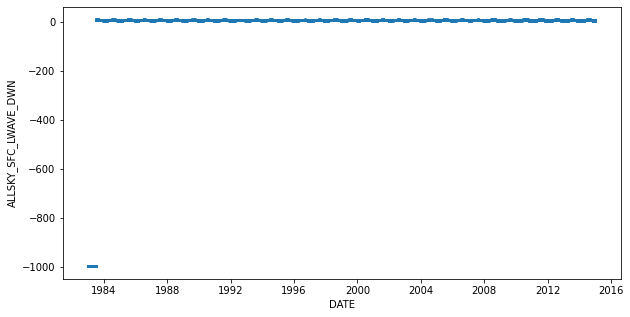

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.scatter(df.index, df.ALLSKY_SFC_LWAVE_DWN, marker = "." , s =15)
plt.xlabel("DATE")
plt.ylabel("ALLSKY_SFC_LWAVE_DWN")

In column "ALLSKY_SFC_LWAVE_DWN" all the -999 values are in the first date position, so probabily it can be possible to remove all the first 181 rows of the data frame without losing much information. Now I will see where the -999 values are in the column "ALLSKY_SFC_SWAVE_DWN".

Text(0, 0.5, 'ALLSKY_SFC_SWAVE_DWN')

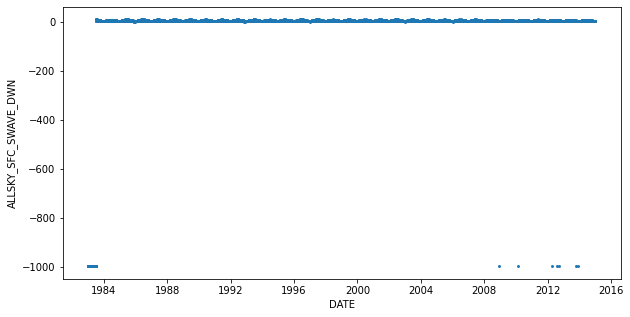

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df.index, df.ALLSKY_SFC_SWAVE_DWN, marker = "." , s =15)
plt.xlabel("DATE")
plt.ylabel("ALLSKY_SFC_SWAVE_DWN")


Unfortunately there are also -999 values spread after the Date 2008. 

The first dataframe rows around the zero index can be removed without any problem but the others not because it's not possible to break time series. There are 2 different option to consider: the first is to controll the correlation between the columns "ALLSKY_SFC_LWAVE_DWN" and "ALLSKY_SFC_SWAVE_DWN" if they are strongly correlated it's possible to remove the latter column; the second is to use some techniques to insert the missing values if the two columns above mentioned are not correlated. Before evaluating the correlation it's important to select a region where there isn't any -999 value with a boolean masking.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


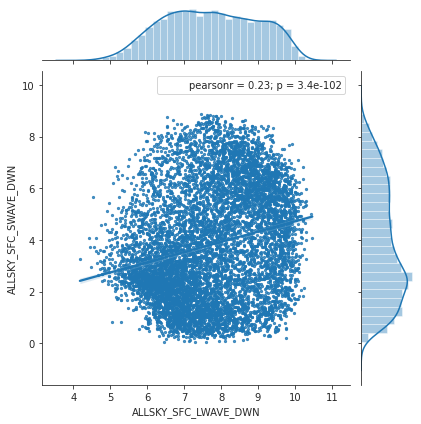

In [ ]:
import seaborn as sns
import scipy.stats as stats
sns.set_style("ticks")
sns.jointplot(x = df.ALLSKY_SFC_LWAVE_DWN.mask(df.index <='1984/12/12').mask(df.index >='2008/1/1' ), 
              y = df.ALLSKY_SFC_SWAVE_DWN.mask(df.index <='1984/12/12').mask(df.index >= '2008/1/1'), 
              data = df, scatter_kws={"s":5}, kind = "reg" ).annotate(stats.pearsonr)


The two variables aren't correlated so it's necessary to insert the missing values using the method **k-Nearest Neighbors**. But firstly I will remove the first 181 rows from the dataframe in order to eliminate the -999 values from both the columns.

The advantages of using KNN imputation are: 
a creation of predictive model for each attribute with missing data is not required; the correlation structure of the data is taken into consideration; thanks to the fact that the database used is not large the algorithm will not be time-consuming.


In [ ]:
df.head(182)

PREC_TOT  SURFACE_PRES  ...  T_2M_DEW  ALLSKY_SFC_SWAVE_DWN
DATE                                ...                                
1983-01-01      0.05        100.98  ...     -2.70               -999.00
1983-01-02      0.04        100.65  ...     -1.58               -999.00
1983-01-03      0.14        100.77  ...     -4.90               -999.00
1983-01-04      1.11        102.25  ...     -8.76               -999.00
1983-01-05      7.28        101.56  ...      1.53               -999.00
...              ...           ...  ...       ...                   ...
1983-06-27      4.53        100.30  ...     19.76               -999.00
1983-06-28     25.66        100.15  ...     18.99               -999.00
1983-06-29      4.68        100.55  ...     13.33               -999.00
1983-06-30      0.00        100.93  ...     13.42               -999.00
1983-07-01      0.02        100.52  ...     18.55                  3.34

[182 rows x 16 columns]

In [ ]:
#remove rows with a boolean masking
df_rmv_rows = df[df.index >= '1983-07-01']
df_rmv_rows.head(5)

PREC_TOT  SURFACE_PRES  ...  T_2M_DEW  ALLSKY_SFC_SWAVE_DWN
DATE                                ...                                
1983-07-01      0.02        100.52  ...     18.55                  3.34
1983-07-02      0.08        100.26  ...     22.06                  6.22
1983-07-03      0.11        100.56  ...     22.46                  7.69
1983-07-04      3.21        100.38  ...     23.40                  5.60
1983-07-05      4.44         99.87  ...     22.04                  3.80

[5 rows x 16 columns]

In [ ]:
#how many -999 values left per column  
df_rmv_rows.isin([-999]).sum(axis=0)

PREC_TOT                0
SURFACE_PRES            0
REL_HUMIDITY_2M         0
T_2M_MAX                0
T_2M_MIN                0
T_2M                    0
WINDSPEED_10M_MIN       0
WINDSPEED_10M_MAX       0
WINDSPEED_50M_MIN       0
WINDSPEED_50M_MAX       0
WINDSPEED_50M           0
WINDSPEED_10M           0
SPEC_HUMIDITY_2M        0
ALLSKY_SFC_LWAVE_DWN    0
T_2M_DEW                0
ALLSKY_SFC_SWAVE_DWN    7
dtype: int64

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=-999, n_neighbors=5)
df_np =imputer.fit_transform(df_rmv_rows)
df_np

array([[ 2.0000e-02,  1.0052e+02,  8.7500e+01, ...,  9.8400e+00,
         1.8550e+01,  3.3400e+00],
       [ 8.0000e-02,  1.0026e+02,  8.6410e+01, ...,  9.7000e+00,
         2.2060e+01,  6.2200e+00],
       [ 1.1000e-01,  1.0056e+02,  8.1610e+01, ...,  9.4600e+00,
         2.2460e+01,  7.6900e+00],
       ...,
       [ 2.0000e-02,  1.0152e+02,  7.5400e+01, ...,  5.8300e+00,
        -5.9900e+00,  1.7400e+00],
       [ 0.0000e+00,  1.0132e+02,  6.7330e+01, ...,  4.9800e+00,
        -7.9400e+00,  2.3300e+00],
       [ 0.0000e+00,  1.0061e+02,  7.2020e+01, ...,  4.9800e+00,
        -6.3100e+00,  2.4600e+00]])

In [ ]:
#transform the numpy array obtained in a dataframe with dtype float64
df2 = pd.DataFrame(df_np, dtype = 'float64')
#take the list of columns in order to recreate the dataframe with all the right column names
columns = list(df_rmv_rows)
#take the Date index
Date = df_rmv_rows.index.values
#set the column names in the new dataframe
df2 = df2.set_axis(columns, axis=1, inplace=False)
#set the date index in the new dataframe
df2 = df2.set_index(Date)
df2.head(10)

PREC_TOT  SURFACE_PRES  ...  T_2M_DEW  ALLSKY_SFC_SWAVE_DWN
1983-07-01      0.02        100.52  ...     18.55                  3.34
1983-07-02      0.08        100.26  ...     22.06                  6.22
1983-07-03      0.11        100.56  ...     22.46                  7.69
1983-07-04      3.21        100.38  ...     23.40                  5.60
1983-07-05      4.44         99.87  ...     22.04                  3.80
1983-07-06      1.48        100.30  ...     16.48                  5.91
1983-07-07      0.00        101.13  ...     12.68                  8.23
1983-07-08      0.00        101.08  ...     15.03                  8.21
1983-07-09      0.00        100.26  ...     16.02                  6.88
1983-07-10      0.00        100.33  ...     11.26                  8.46

[10 rows x 16 columns]

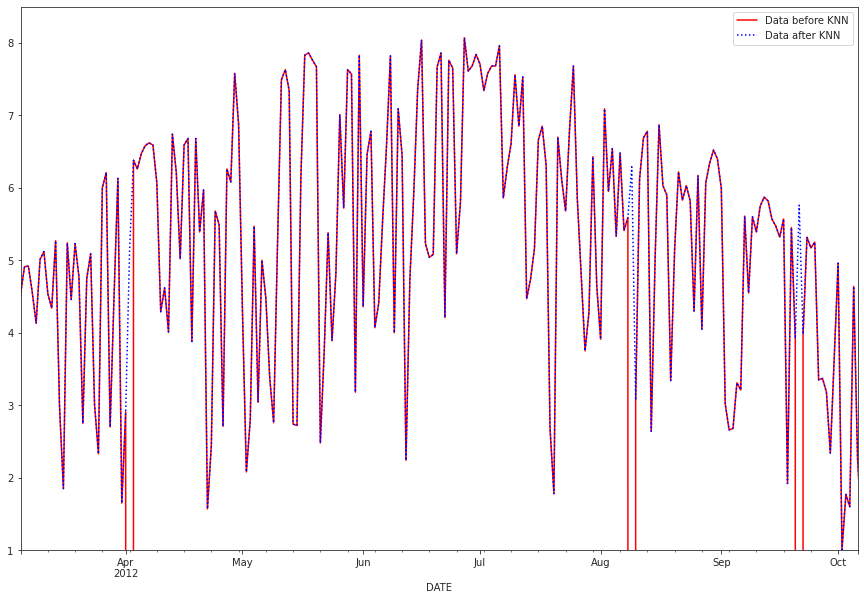

In [ ]:
plt.figure(figsize=(15,10))
ax = df_rmv_rows['ALLSKY_SFC_SWAVE_DWN'].plot(color = 'red', label = 'Data before KNN')
df2['ALLSKY_SFC_SWAVE_DWN'].plot(ax=ax, color = 'b', linestyle = ':', label = 'Data after KNN')
plt.ylim(1, 8.5)
plt.xlim('2012/3/5', '2012/10/6')
plt.legend()


* **Data distribution and outliers**

Looking at the feature histograms is possible to notice that the variables relative to the wind speed and the precipitation have a positive skewed distribution. While the features relative to the temperature and the variables ALLSKY_SFC_LWAVE_DWN and ALLSKY_SFC_SWAVE_DWN have a multimodal distribution probably due to two different sets of environmental circumstances. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ecb595f60>,
      dtype=object)

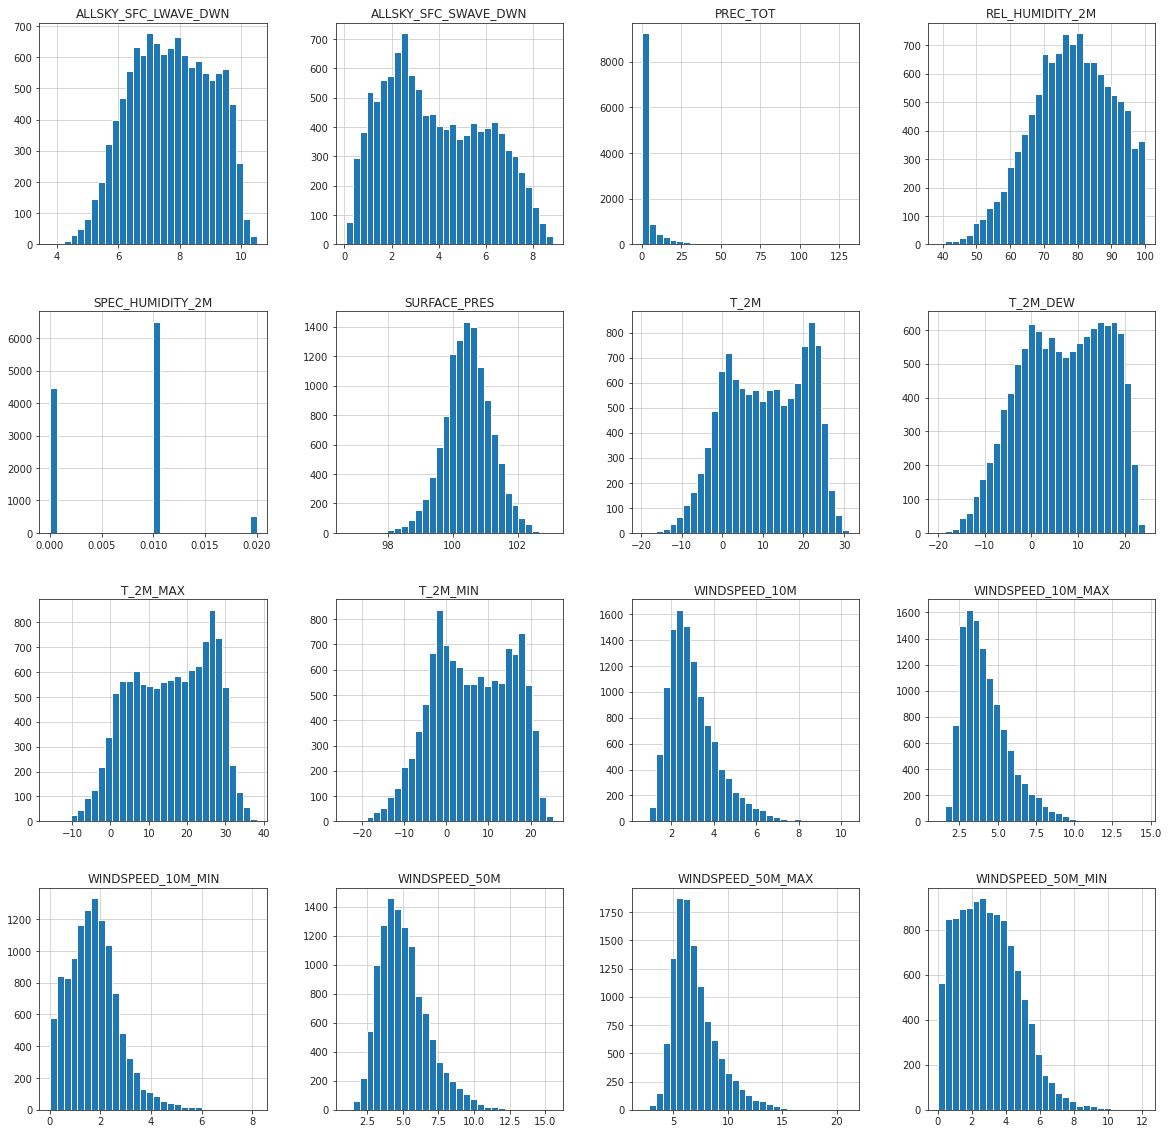

In [ ]:
df2.hist(bins=30, figsize=(20, 20))

The REL_HUMIDITY_2M has a negative skewed distribution, while SPEC_HUMIDITY_2M assumes only 3 values so I will investigate this behavior. Since there is a mathematical expression to calculate this variable from the temperature, the surface pressure and the relative humidity let's see how the obtained distribution would be.

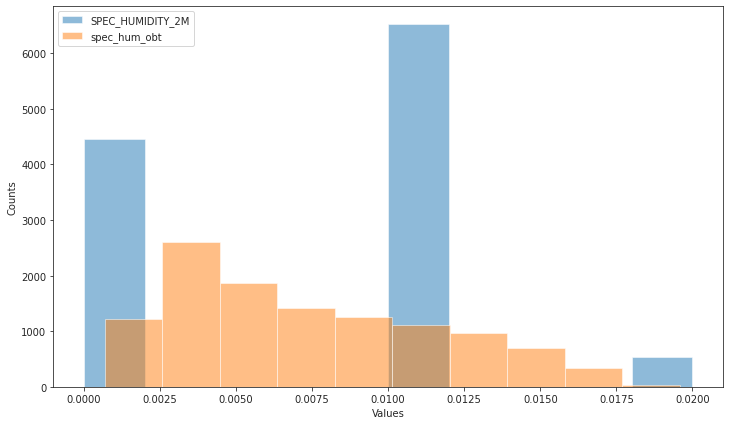

In [ ]:
#calculation of the variables
vap_pres = 6.11*10.0**(7.5*df2.T_2M/(237.7+df2.T_2M)) #vapor pressure
mix_r = 622.0*vap_pres/(df2.SURFACE_PRES*10.0-vap_pres) #mixing ratio
spec_hum_obt =  mix_r*df2.REL_HUMIDITY_2M/100000.0 #specific humidity obtained in kg kg-1
#plot
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(12,7))
ax.hist(df2.SPEC_HUMIDITY_2M, bins=10, alpha=0.5, label = 'SPEC_HUMIDITY_2M')
ax.hist(spec_hum_obt, bins=10, alpha=0.5, label = 'spec_hum_obt')
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
ax.legend(loc='upper left')

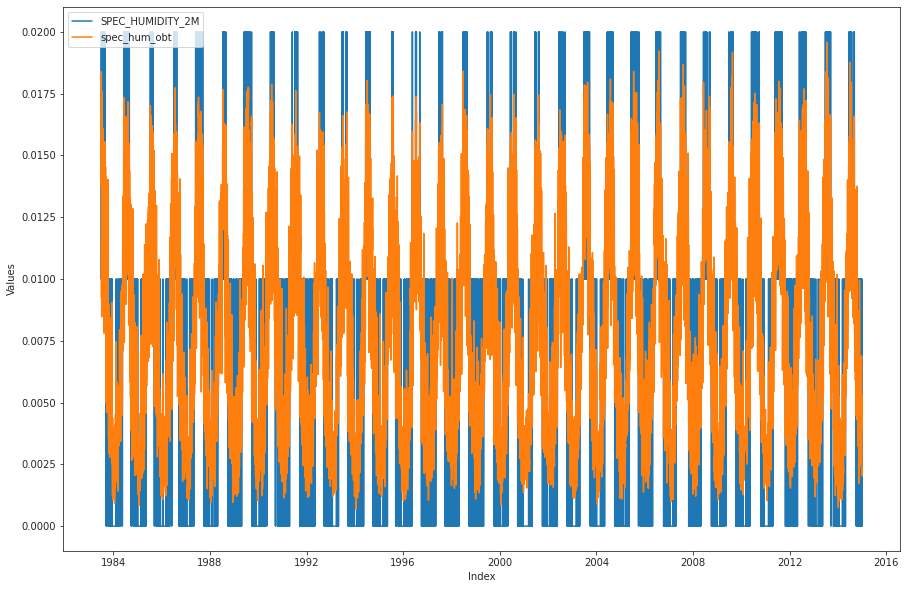

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(15,10))
ax.plot(df2.SPEC_HUMIDITY_2M,  label = 'SPEC_HUMIDITY_2M')
ax.plot(spec_hum_obt, label = 'spec_hum_obt')
ax.set_ylabel('Values')
ax.set_xlabel('Index')
ax.legend(loc='upper left')

The specific humidity distribution calculated results very different and in the last plot it can be seen that the oscillations are the same from the NASA ones. So I think it is better to remove this column because probably there have been problems during the variable measurement.

Now let's take a look at some summary stats of the features in order to check for the existence of extreme outliers. The DataFrame method .describe() will produce a DataFrame containing the count, mean, standard deviation, min, 25th percentile, 50th percentile (or median), the 75th percentile and the max value. 
Another output column is added to indicate the existence of outliers. The rule of thumb to identify an extreme outlier is a value that is less than 3 interquartile ranges below the 25th percentile, or 3 interquartile ranges above the 75th percentile, where the interquartile range is the difference between the 75th percentile and the 25th percentile.

In [ ]:
#remove the specific humidity variable
del df2['SPEC_HUMIDITY_2M']

# Call describe on df2 and transpose it in order to have a more tidy table
t = df2.describe().T
#Interquartile range calculation
IQR = t['75%'] - t['25%']
# create the outliers column 
t['outliers'] = (t['min']<(t['25%']-(3*IQR)))|(t['max'] > (t['75%']+3*IQR))
# just display the features containing extreme outliers
t.loc[t.outliers,]

count        mean       std  ...       75%     max  outliers
PREC_TOT           11508.0    3.295174  7.565285  ...    2.7100  131.26      True
SURFACE_PRES       11508.0  100.455868  0.728788  ...  100.9300  103.09      True
WINDSPEED_10M_MIN  11508.0    1.736601  1.011142  ...    2.3100    8.18      True
WINDSPEED_10M_MAX  11508.0    4.221905  1.579315  ...    5.0500   14.64      True
WINDSPEED_50M_MIN  11508.0    2.941128  1.782929  ...    4.1300   12.19      True
WINDSPEED_50M_MAX  11508.0    6.994968  2.108169  ...    7.9600   21.12      True
WINDSPEED_50M      11508.0    5.080255  1.734242  ...    6.0100   15.54      True
WINDSPEED_10M      11508.0    3.009765  1.161181  ...    3.5825   10.36      True

[8 rows x 9 columns]

Now I will closely at these features in a graphical way using histograms and boxplots together.



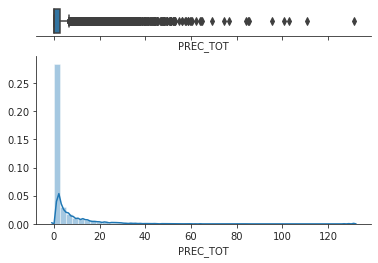

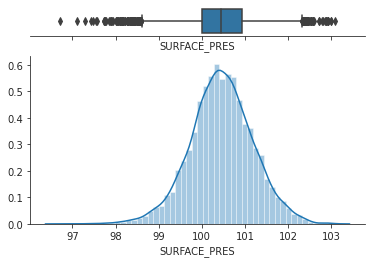

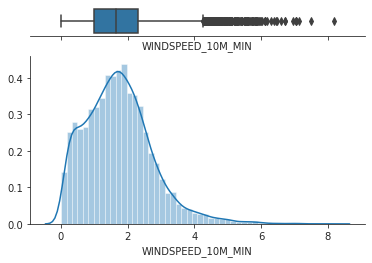

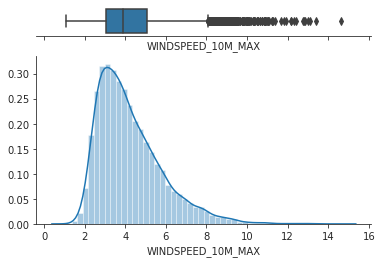

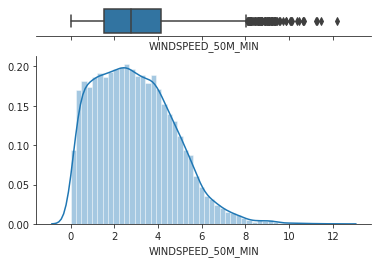

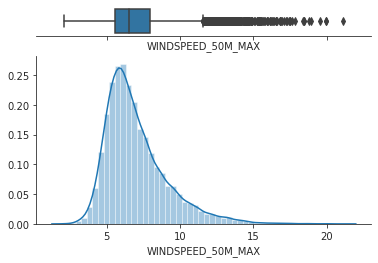

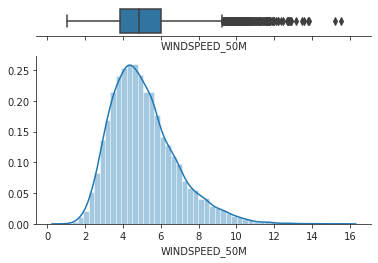

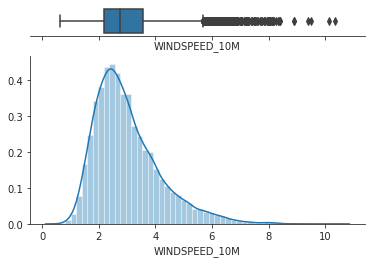

In [ ]:
#traspose to use the previous rows as columns
for column in t.loc[t.outliers,].T:
  #boxplot above the histogram
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
  sns.boxplot(df2[column], ax=ax_box)
  sns.distplot(df2[column], ax=ax_hist)
  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)


* **PREC_TOT**: the positive skewness is easy to understand, since the dry days (no precipitation) are much more frequent, it's normal to see outliers.
* **SURFACE_PRES**: the data seems to have a multimodal distribution, probably due to two different sets of environmental circumstances like the features relative to temperature and the variables ALLSKY_SFC_LWAVE_DWN and ALLSKY_SFC_SWAVE_DWN. 
* **WINDSPEED**: all the wind speed features have a positive skewed distribution.

I will not remove these outliers since I know that the swings of these variables can be quite significant especially between seasons of the year so I can't consider these points as a measurement error. 
In conclusion since the variables are not normally distributed I will avoid the models that require normally distributed data.

* **Stationarity/Non-Stationarity**

Looking at the plot of all the variable there seems to be no trend but only seasonal cycles in some features. I will use a statistical test to check if the features are stationary or not.

**Augmented Dickey-Fuller Test Statistical Test**

I will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.
The Null and Alternate hypothesis of the Augmented Dickey-Fuller test are defined as follows:

* **Null Hypothesis** states there is the presence of a unit root (non-stationarity)
* **Alternate Hypothesis** states there is no unit root (stationarity)

The adfuller function returns a tuple of statistics from the ADF test such as the Test Statistic, P-Value, Number of Lags Used, Number of Observations used for the ADF regression and a dictionary of Critical Values.

If the P-Value is less than the Significance Level defined, I will reject the Null Hypothesis that the time series contains a unit root. In other words, by rejecting the Null hypothesis, I can conclude that the time series is stationary. If the P-Value is very close to your significance level, the Critical Values can be used to help to reach a conclusion regarding the stationarity of the time series.



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e6bcccc50>,
      dtype=object)

<Figure size 864x864 with 0 Axes>

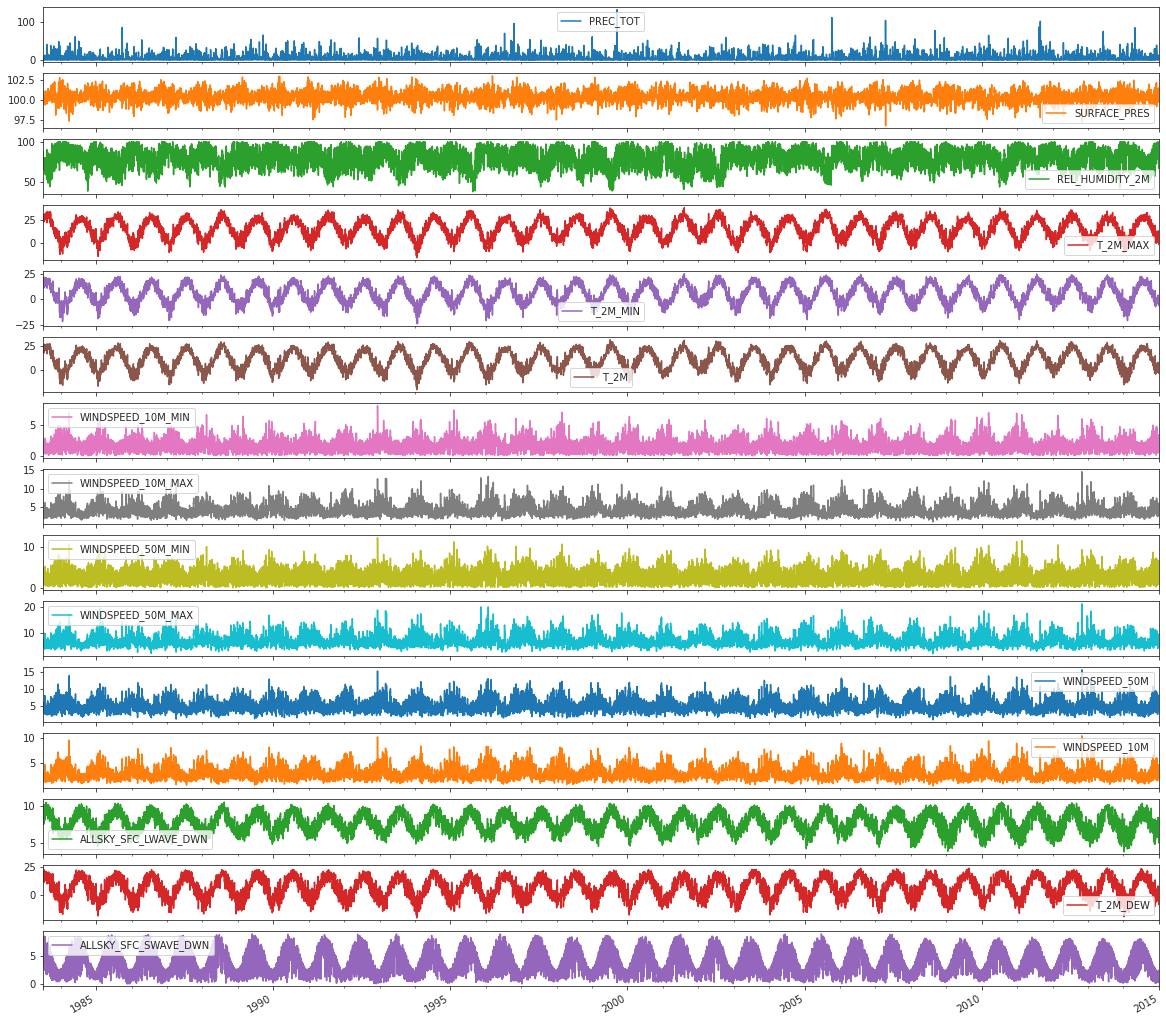

In [ ]:
plt.figure(figsize = (12,12))
df2.plot(subplots=True, figsize = (20,20))

In [ ]:
import statsmodels
from statsmodels.tsa.stattools import adfuller 

In [ ]:
#significance level of 5%  
# 'isStationary' variable will hold the results of the ADF test:
#If the time series is stationary, isStationary will be True, otherwise it will be False.

significance = 0.05
isStationary = None

dfResults = pd.DataFrame()
     
df2_result = pd.DataFrame()
for col in df2.columns.values:
  adfTest = adfuller(df2[col], autolag='AIC')  #Akaike Information Criterion (AIC) is used to determine the lag.
  p_value = adfTest[1] 
  if (adfTest[1]< significance):
    isStationary = True
  else:
    isStationary = False
  df2_result = df2_result.append(pd.DataFrame(index =[col], data={'ADF Test Statistic': adfTest[0],'P-Value': adfTest[1],
                                                                  '# Lags Used': adfTest[2],'# Observations Used':adfTest[3], 
                                                                  "Is the variable stationary?":isStationary  }))

df2_result

ADF Test Statistic  ...  Is the variable stationary?
PREC_TOT                      -74.510972  ...                         True
SURFACE_PRES                  -18.102152  ...                         True
REL_HUMIDITY_2M                -9.753353  ...                         True
T_2M_MAX                       -8.275975  ...                         True
T_2M_MIN                       -7.860217  ...                         True
T_2M                           -8.355465  ...                         True
WINDSPEED_10M_MIN              -8.929405  ...                         True
WINDSPEED_10M_MAX              -8.823353  ...                         True
WINDSPEED_50M_MIN              -9.284829  ...                         True
WINDSPEED_50M_MAX              -8.983335  ...                         True
WINDSPEED_50M                  -9.028478  ...                         True
WINDSPEED_10M                  -8.538214  ...                         True
ALLSKY_SFC_LWAVE_DWN           -6.371426  ...                         True
T_2M_DEW                       -7.363025  ...                         True
ALLSKY_SFC_SWAVE_DWN           -6.637510  ...                         True

[15 rows x 5 columns]

All the variables turn to be stationary so the implementation of the SARIMA model will be more easier because we have not to make the variables stationary.

In [ ]:
#create copies of the dataframe for the 3 models
#for sarima models
df_ar = df2.copy()
#for dnn regressor
df_dnn = df2.copy()
#for lstm
df_lstm = df2.copy()

# **SARIMA (Seasonal Auto-Regressive Integrated Moving Averages)**

The SARIMA model is an approach for modeling univariate time series that contain trend and seasonal components. It is a models that 'explains' a given time series based on its own past values.
The model works on the following assumption: 
* no missing values
* data series must be stationary.

Firstly I will use only the T_2M variable to make predictons.

Configuring a SARIMA model [SARIMA(p,d,q)(P,D,Q)m] requires selecting hyperparameters for both the trend and the seasonal element of the series. These hyperparameters are:
* **p**: trend autoregression order
* **d**: trend difference order
* **q**: trend moving average order
* **P**: seasonal autorefressive order
* **D**: seasonal difference order
* **Q**: seasonal moving average order
* **m**: number of time steps for a single seasonal period

Instead of analize the autocorrelation and partial autocorrelation plots to configure the model, an alternative approach, that saves time, consists of using the auto.arima function in order to have the optimal model configuration, combaining the unit root tests and the minimisation of the AIC and MLE.

In [ ]:
import numpy as np
#take the temperature series from the dataframe
t_2m = df_ar.T_2M
# split data into training set and test set 
n_of_split = int(len(t_2m)*0.99)
t_2m, test_t = np.split(t_2m, [n_of_split])


In [ ]:
test_t.shape

(116,)

The model predictions will be compared to the test set (test_t, that represents 116 days of temperature), while the model is trained on the training set (t_2m).

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 16.7MB/s 
     |████████████████████████████████| 2.1MB 45.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20


In [ ]:
from numpy import nan
import pmdarima as pm
stepwise_fit = pm.auto_arima(
  t_2m,  #univariate series
  d = nan, #Order of first-differencing. If missing, will choose a value based on test.
  D = nan, #Order of seasonal-differencing. If missing, will choose a value based on 'season.test'.
  max_p = 5, #Maximum value of p
  max_q = 5, #Maximum value of q
  max_P = 2, #Maximum value of P
  max_Q = 2, #Maximum value of Q
  #max_order = 5, #Maximum value of p+q+P+Q if model selection is not stepwise.
  max_d = 2, #Maximum number of non-seasonal differences
  max_D = 1, #Maximum number of seasonal differences
  start_p = 2, #Starting value of p in stepwise procedure.
  start_q = 2, #Starting value of q in stepwise procedure.
  start_P = 1, #Starting value of P in stepwise procedure.
  start_Q = 1, #Starting value of Q in stepwise procedure.
  stationary = True, #If TRUE, restricts search to stationary models.
  seasonal = True, #If FALSE, restricts search to non-seasonal models.
  stepwise = True, #If TRUE, will do stepwise selection (faster). Otherwise, it searches over all models. 
                   #Non-stepwise selection can be very slow, especially for seasonal models.
  nmodels = 94, #Maximum number of models considered in the stepwise search.
  trace = False, #If TRUE, the list of ARIMA models considered will be reported.
  approximation = True, #If TRUE, estimation is via conditional sums of squares and the information criteria used for model selection are approximated. 
                 #The final model is still computed using maximum likelihood estimation. 
                 #Approximation should be used for long time series or a high seasonal period to avoid excessive computation times.
  truncate = None, #An integer value indicating how many observations to use in model selection. 
                   # All observations are used if either truncate=NULL.
  xreg = None, #Optionally, a numerical vector or matrix of external regressors, which must have the same number of rows as y. (It should not be a data frame.)
  test = "adf", #Type of unit root test to use.
)

stepwise_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmo

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11392
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -27243.077
Date:                Mon, 22 Jun 2020   AIC                          54500.153
Time:                        14:04:56   BIC                          54551.538
Sample:                             0   HQIC                         54517.435
                              - 11392                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0375      0.008      4.427      0.000       0.021       0.054
ar.L1          1.4020      0.030     47.041      0.000       1.344       1.460
ar.L2         -0.4514      0.052     -8.723      0.000      -0.553      -0.350
ar.L3          0.0460      0.025      1.871      0.061      -0.002       0.094
ma.L1         -0.4770      0.029    -16.470      0.000      -0.534      -0.420
ma.L2         -0.2909      0.028    -10.526      0.000      -0.345      -0.237
sigma2         6.9913      0.077     90.556      0.000       6.840       7.143
===================================================================================
Ljung-Box (Q):                      185.33   Jarque-Bera (JB):              1082.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.44
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now I will build the SARIMA model by using the optimal parameter values found. 
Then the model summary is printed.


In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(t_2m, order = (3,0,2))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   T_2M   No. Observations:                11392
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -27252.484
Date:                Mon, 22 Jun 2020   AIC                          54516.969
Time:                        14:05:26   BIC                          54561.013
Sample:                    07-01-1983   HQIC                         54531.781
                         - 09-07-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4057      0.030     47.296      0.000       1.347       1.464
ar.L2         -0.4513      0.052     -8.702      0.000      -0.553      -0.350
ar.L3          0.0443      0.025      1.802      0.0

The summary returns a significant amount of information, but I will focus the attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column gives the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in the model.

It is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows to quickly generate model diagnostics and investigate for any unusual behavior.

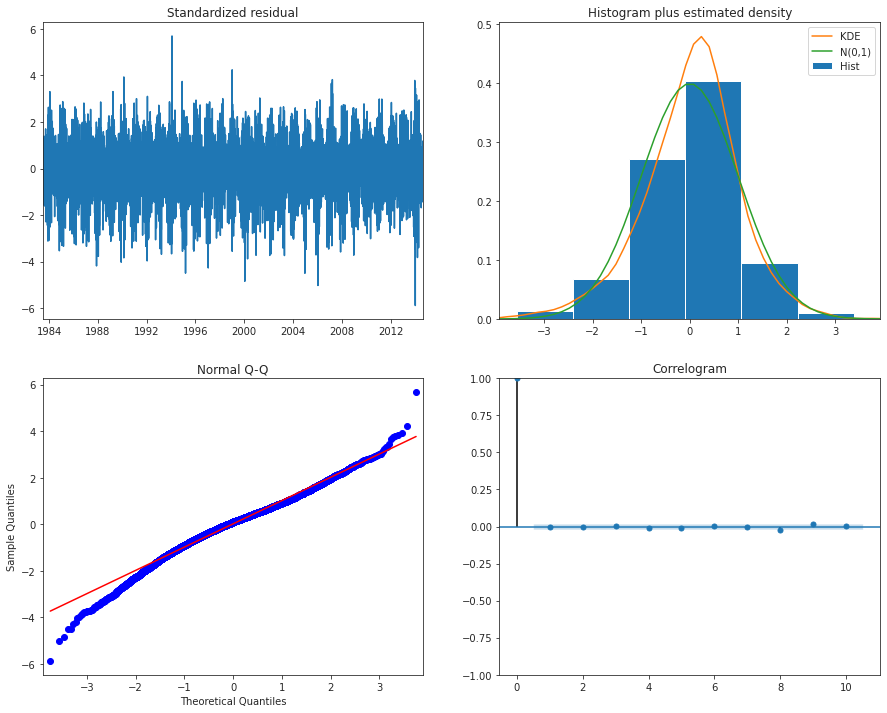

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

* In the top right plot, it can be seen that the red KDE line does not closely follow the N(0,1) line (where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This indicates that the residuals don't follow perfectly the normal distribution.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) has heavy tails especially on the left. The points fall along the standard normal distribution (with N(0, 1)) line in the middle of the graph, but curve off in the extremities. This means that probably the residuals have more extreme values than would be expected.
* The residuals over time (top left plot) don’t display any obvious seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that the model produces an almost satisfactory fit.


Now I want to use the the forecast() function, which performs a one-step forecast using the model, so I will generate a prediction for each element on the test set.
A rolling forecast is required given the dependence on observations in prior time steps. A way to perform this rolling forecast is to re-create the model after each new observation is received keeping track of all observations in a list called history that is seeded with the training data and to which new observations are appended in each iteration.

In [ ]:
history = [x for x in t_2m]
predictions = list()
for t in range(len(test_t)):
  model = sm.tsa.statespace.SARIMAX(history, order=(3,0,2))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_t[t]
  history.append(obs)
  


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The forecast is done over the test data period in order to compare the predicted values to the actual ones of test dataset.



In [ ]:
import numpy as np
#true values
y_truth = test_t  
y_forecasted = predictions
#Compute the mean square error
mse_ar = ((y_forecasted - y_truth) ** 2)
#Calculate the Mean Arctangent Absolute Percentage Error
maape_ar = (np.arctan(np.abs((y_truth -y_forecasted)/y_truth )))

print('SARIMA')
print('MSE: {}'.format(round(mse_ar.mean(), 2)))
print('MAAPE: {:.2%}'.format(maape_ar.mean()))


SARIMA
MSE: 7.71
MAAPE: 41.35%


In [ ]:
#transform predictions in a dataframe with dtype float64
y_forecasted = pd.DataFrame(predictions, dtype = 'float64')
y_truth= pd.DataFrame(test_t, dtype = 'float64')
#take the Date index
Date = test_t.index.values
#set the index in the dataframe
y_forecasted = y_forecasted.set_index(Date)
y_truth = y_truth.set_index(Date)


Now I will plot the real and forecasted values of the T_2M.

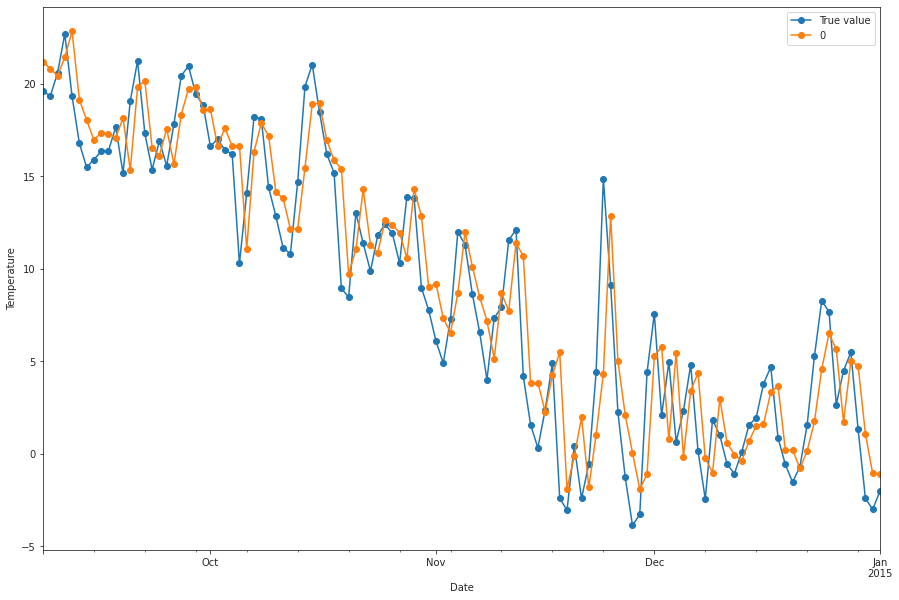

In [ ]:
plt.figure(figsize = (15,10))
ax = test_t.plot(marker='o',label='True value')
y_forecasted.plot(ax=ax, marker='o',label='Prediction')
#ax.axis(xmin='2010-01-01',xmax='2010-01-10')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()


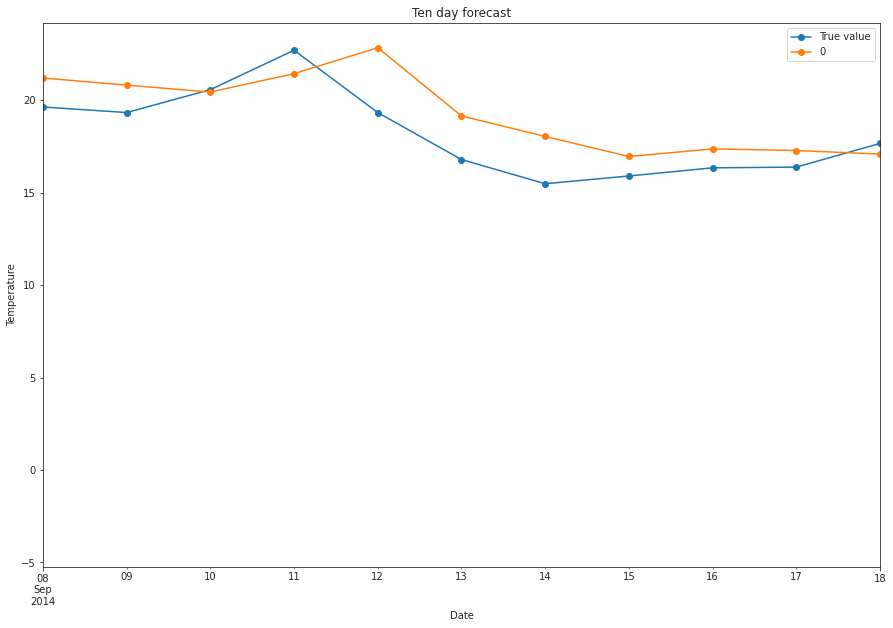

In [ ]:
plt.figure(figsize = (15,10))
ax = test_t.plot(marker='o',label='True value')
y_forecasted.plot(ax=ax, marker='o',label='Prediction')
ax.axis(xmin='2014-09-08',xmax='2014-09-18')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Ten day forecast')
plt.legend()

The MSE yields a value of 7.71 which is not close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario.
Both MAAPE and MSE shows that the fit is not so good.


* **SARIMA with normalized and standardized temperature**

Now I will analyze the SARIMA model with the normalized and the standardized  temperature. 

In [ ]:
#normalization and splitting
df2_norm=(df_ar-df_ar.min())/(df_ar.max()-df_ar.min())
t_2m_norm = df2_norm.T_2M
n_of_split = int(len(t_2m)*0.99)
t_2m_norm, test_t_n = np.split(t_2m_norm, [n_of_split])

#standardization and splitting
df2_stand = (df_ar - df_ar.mean())/df_ar.std()
t_2m_stand = df2_stand.T_2M
t_2m_stand, test_t_s= np.split(t_2m_stand, [n_of_split])


In [ ]:
#auto arima for the normalized temperature
stepwise_fit_norm = pm.auto_arima(
  t_2m_norm,  #univariate series normalized
  d = nan, #Order of first-differencing. If missing, will choose a value based on test.
  D = nan, #Order of seasonal-differencing. If missing, will choose a value based on 'season.test'.
  max_p = 5, #Maximum value of p
  max_q = 5, #Maximum value of q
  max_P = 2, #Maximum value of P
  max_Q = 2, #Maximum value of Q
  #max_order = 5, #Maximum value of p+q+P+Q if model selection is not stepwise.
  max_d = 2, #Maximum number of non-seasonal differences
  max_D = 1, #Maximum number of seasonal differences
  start_p = 2, #Starting value of p in stepwise procedure.
  start_q = 2, #Starting value of q in stepwise procedure.
  start_P = 1, #Starting value of P in stepwise procedure.
  start_Q = 1, #Starting value of Q in stepwise procedure.
  stationary = True, #If TRUE, restricts search to stationary models.
  seasonal = True, #If FALSE, restricts search to non-seasonal models.
  stepwise = True, #If TRUE, will do stepwise selection (faster). Otherwise, it searches over all models. 
                   #Non-stepwise selection can be very slow, especially for seasonal models.
  nmodels = 94, #Maximum number of models considered in the stepwise search.
  trace = False, #If TRUE, the list of ARIMA models considered will be reported.
  approximation = True, #If TRUE, estimation is via conditional sums of squares and the information criteria used for model selection are approximated. 
                 #The final model is still computed using maximum likelihood estimation. 
                 #Approximation should be used for long time series or a high seasonal period to avoid excessive computation times.
  truncate = None, #An integer value indicating how many observations to use in model selection. 
                   # All observations are used if either truncate=NULL.
  xreg = None, #Optionally, a numerical vector or matrix of external regressors, which must have the same number of rows as y. (It should not be a data frame.)
  test = "adf", #Type of unit root test to use.
)

stepwise_fit_norm.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimiza

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11278
Model:               SARIMAX(4, 0, 5)   Log Likelihood               17337.008
Date:                Mon, 22 Jun 2020   AIC                         -34652.016
Time:                        09:44:21   BIC                         -34571.380
Sample:                             0   HQIC                        -34624.884
                              - 11278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.001      4.652      0.000       0.004       0.010
ar.L1          0.7354      0.204      3.601      0.000       0.335       1.136
ar.L2         -0.2176      0.293     -0.742      0.458      -0.792       0.357
ar.L3          0.4892      0.261      1.873      0.061      -0.023       1.001
ar.L4         -0.0184      0.089     -0.206      0.836      -0.193       0.156
ma.L1          0.1827      0.204      0.895      0.371      -0.217       0.583
ma.L2          0.0943      0.192      0.491      0.623      -0.282       0.470
ma.L3         -0.2933      0.126     -2.332      0.020      -0.540      -0.047
ma.L4         -0.2581      0.066     -3.936      0.000      -0.387      -0.130
ma.L5         -0.0920      0.023     -4.070      0.000      -0.136      -0.048
sigma2         0.0027   3.02e-05     89.696      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                      187.41   Jarque-Bera (JB):              1067.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.44
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_norm = sm.tsa.statespace.SARIMAX(t_2m_norm, order=(4,0,5)) 
results_norm = model_norm.fit()
print(results_norm.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   T_2M   No. Observations:                11278
Model:               SARIMAX(4, 0, 5)   Log Likelihood               17323.526
Date:                Mon, 22 Jun 2020   AIC                         -34627.052
Time:                        09:44:58   BIC                         -34553.746
Sample:                    07-01-1983   HQIC                        -34602.386
                         - 05-16-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8406      0.288      2.918      0.004       0.276       1.405
ar.L2         -0.2911      0.436     -0.668      0.504      -1.145       0.563
ar.L3          0.5355      0.379      1.414      0.1

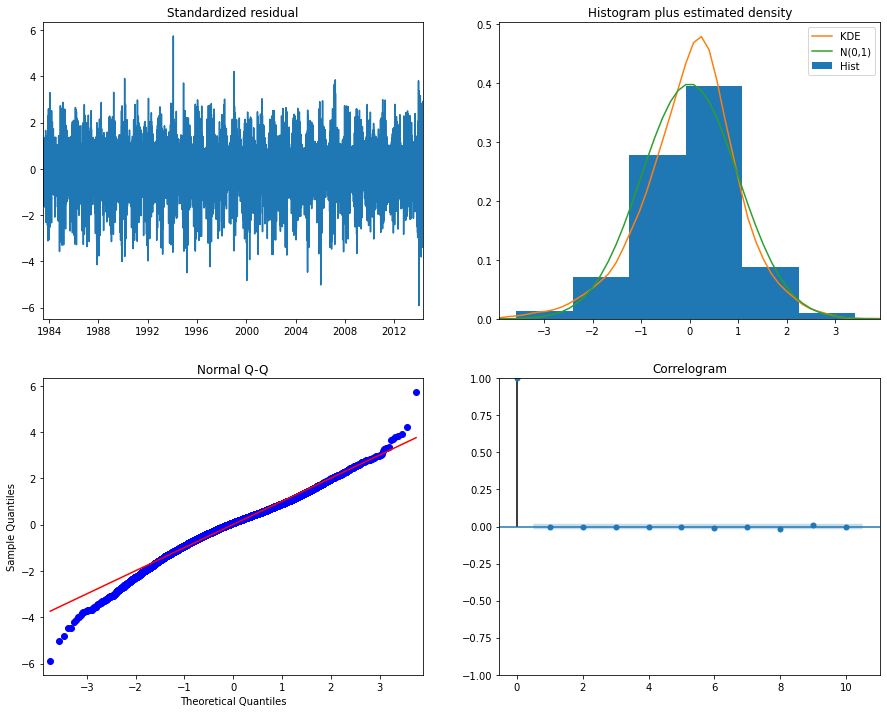

In [ ]:
results_norm.plot_diagnostics(figsize=(15, 12))
plt.show()

Again the residuals don't follow perfectly the normal distribution.
In the qq-plot the residuals probably have more extreme values than would be expected.
The residuals over time don’t display any obvious seasonality. The correlogram shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that the model produces an almost satisfactory fit.

Now the model can be used to make predictions. 

In [ ]:
history_n = [x for x in t_2m_norm]
predictions_norm = list()
for t in range(len(test_t_n)):
  model_norm = sm.tsa.statespace.SARIMAX(history_n, order=(4,0,5))
  model_fit = model_norm.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions_norm.append(yhat)
  obs = test_t_n[t]
  history_n.append(obs)
  


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [ ]:
import numpy as np
#true values
y_truth_n = test_t_n 
#predicted values
y_forecasted_n = predictions_norm
#Compute the mean square error
mse_ar_n = ((y_forecasted_n - y_truth_n) ** 2)
#Calculate the Mean Arctangent Absolute Percentage Error
maape_ar_n = (np.arctan(np.abs((y_truth_n -y_forecasted_n)/y_truth_n )))

print('SARIMA')
print('MSE: {}'.format(round(mse_ar_n.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_ar_n.mean()))


SARIMA
MSE: 0.002
MAAPE: 5.82%


In [ ]:
#transform predictions in a dataframe with dtype float64
y_forecasted_n = pd.DataFrame(predictions_norm, dtype = 'float64')
y_truth_n= pd.DataFrame(test_t_n, dtype = 'float64')
#take the Date index
Date = test_t_n.index.values

#set the index in the dataframe
y_forecasted_n = y_forecasted_n.set_index(Date)
y_truth_n = y_truth_n.set_index(Date)


In [ ]:
#denormalization
ydenorm = (y_forecasted_n*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()
testdenorm = (test_t_n*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()

Text(0, 0.5, 'Temperature')

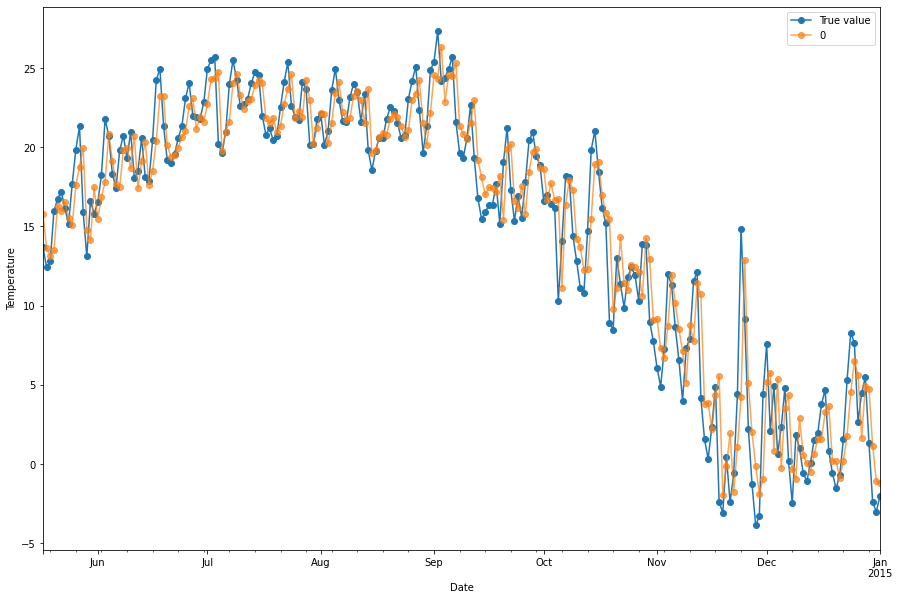

In [ ]:
plt.figure(figsize = (15,10))
ax = testdenorm.plot(marker = 'o',label='True value')
ydenorm.plot(marker = 'o',  label='Prediction',ax=ax, alpha=.7)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')


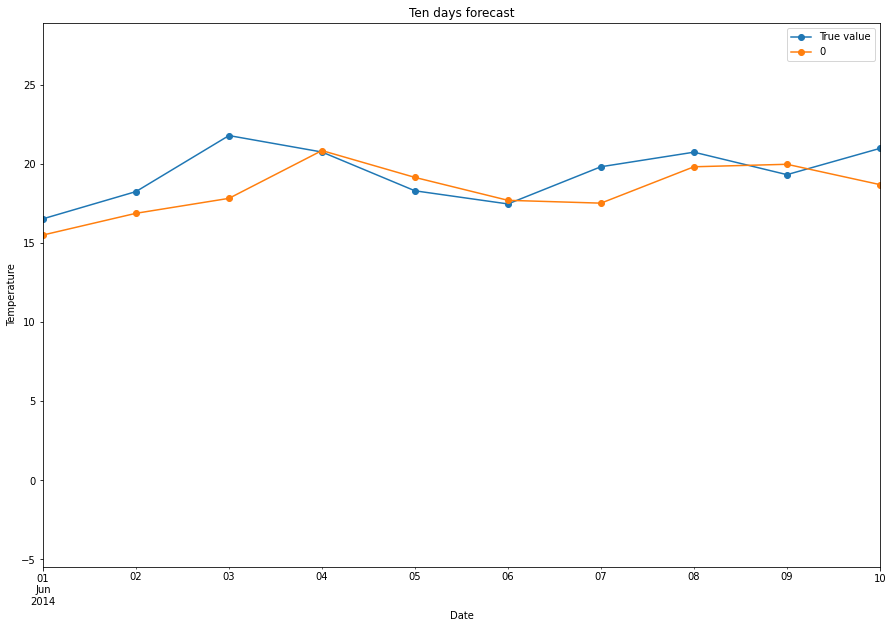

In [ ]:
plt.figure(figsize = (15,10))
ax = testdenorm.plot(marker='o',label='True value')
ydenorm.plot(ax=ax, marker='o',label='Prediction')
ax.axis(xmin='2014-06-01',xmax='2014-06-10')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Ten days forecast')
plt.legend()


In [ ]:
#autoarima for standardized temperature
stepwise_fit_stand = pm.auto_arima(
  t_2m_stand,  #univariate series
  d = nan, #Order of first-differencing. If missing, will choose a value based on test.
  D = nan, #Order of seasonal-differencing. If missing, will choose a value based on 'season.test'.
  max_p = 5, #Maximum value of p
  max_q = 5, #Maximum value of q
  max_P = 2, #Maximum value of P
  max_Q = 2, #Maximum value of Q
  #max_order = 5, #Maximum value of p+q+P+Q if model selection is not stepwise.
  max_d = 2, #Maximum number of non-seasonal differences
  max_D = 1, #Maximum number of seasonal differences
  start_p = 2, #Starting value of p in stepwise procedure.
  start_q = 2, #Starting value of q in stepwise procedure.
  start_P = 1, #Starting value of P in stepwise procedure.
  start_Q = 1, #Starting value of Q in stepwise procedure.
  stationary = True, #If TRUE, restricts search to stationary models.
  seasonal = True, #If FALSE, restricts search to non-seasonal models.
  stepwise = True, #If TRUE, will do stepwise selection (faster). Otherwise, it searches over all models. 
                   #Non-stepwise selection can be very slow, especially for seasonal models.
  nmodels = 94, #Maximum number of models considered in the stepwise search.
  trace = False, #If TRUE, the list of ARIMA models considered will be reported.
  approximation = True, #If TRUE, estimation is via conditional sums of squares and the information criteria used for model selection are approximated. 
                 #The final model is still computed using maximum likelihood estimation. 
                 #Approximation should be used for long time series or a high seasonal period to avoid excessive computation times.
  truncate = None, #An integer value indicating how many observations to use in model selection. 
                   # All observations are used if either truncate=NULL.
  xreg = None, #Optionally, a numerical vector or matrix of external regressors, which must have the same number of rows as y. (It should not be a data frame.)
  test = "adf", #Type of unit root test to use.
)

stepwise_fit_stand.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmo

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11278
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -1284.138
Date:                Mon, 22 Jun 2020   AIC                           2584.276
Time:                        10:58:51   BIC                           2642.921
Sample:                             0   HQIC                          2604.009
                              - 11278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.349e-05      0.001      0.092      0.927      -0.002       0.002
ar.L1          0.9954      0.001    878.563      0.000       0.993       0.998
ma.L1         -0.0707      0.009     -8.295      0.000      -0.087      -0.054
ma.L2         -0.3637      0.009    -41.192      0.000      -0.381      -0.346
ma.L3         -0.1418      0.009    -15.901      0.000      -0.159      -0.124
ma.L4         -0.0490      0.008     -5.962      0.000      -0.065      -0.033
ma.L5         -0.0146      0.009     -1.709      0.087      -0.031       0.002
sigma2         0.0735      0.001     89.905      0.000       0.072       0.075
===================================================================================
Ljung-Box (Q):                      178.34   Jarque-Bera (JB):              1041.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.43
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_stand = sm.tsa.statespace.SARIMAX(t_2m_stand, order=(1,0,5))
results_stand = model_stand.fit()
print(results_stand.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   T_2M   No. Observations:                11278
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -1284.146
Date:                Mon, 22 Jun 2020   AIC                           2582.292
Time:                        10:59:29   BIC                           2633.607
Sample:                    07-01-1983   HQIC                          2599.559
                         - 05-16-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.001    942.832      0.000       0.993       0.997
ma.L1         -0.0706      0.008     -8.353      0.000      -0.087      -0.054
ma.L2         -0.3638      0.009    -41.384      0.0

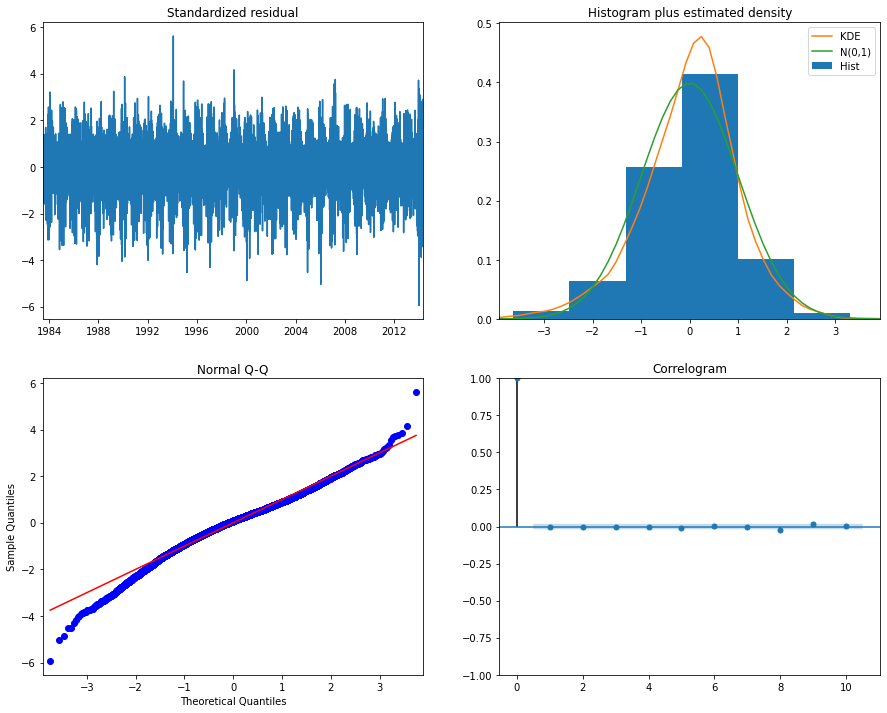

In [ ]:
results_stand.plot_diagnostics(figsize=(15, 12))
plt.show()

The residual distribution presents the same behaviour of the other two previously described.

In [ ]:
history_s = [x for x in t_2m_stand]
predictions_stand = list()
for t in range(len(test_t_s)):
  model_stand = sm.tsa.statespace.SARIMAX(history_s, order=(1,0,5))
  model_fit = model_stand.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions_stand.append(yhat)
  obs = test_t_s[t]
  history_s.append(obs)
  


In [ ]:
import numpy as np
#true values
y_truth_s = test_t_s 
#predicted values
y_forecasted_s = predictions_stand
#Compute the mean square error
mse_ar_s = ((y_forecasted_s - y_truth_s) ** 2)
#Calculate the Mean Arctangent Absolute Percentage Error
maape_ar_s = (np.arctan(np.abs((y_truth_s -y_forecasted_s)/y_truth_s )))

print('SARIMA with standardized data')
print('MSE: {}'.format(round(mse_ar_s.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_ar_s.mean()))


SARIMA
MSE: 0.0551
MAAPE: 27.78%


In [ ]:
#transform predictions in a dataframe with dtype float64
y_forecasted_s = pd.DataFrame(predictions_stand, dtype = 'float64')
y_truth_s= pd.DataFrame(test_t_s, dtype = 'float64')
#take the Date index
Date = test_t_s.index.values

#set the index in the dataframe
y_forecasted_s = y_forecasted_s.set_index(Date)
y_truth_s = y_truth_s.set_index(Date)



In [ ]:
#de-standardize 
ydestand = y_forecasted_s*df2.T_2M.std()+df2.T_2M.mean()
testdestand = test_t_s*df2.T_2M.std()+df2.T_2M.mean()

Text(0, 0.5, 'Temperature')

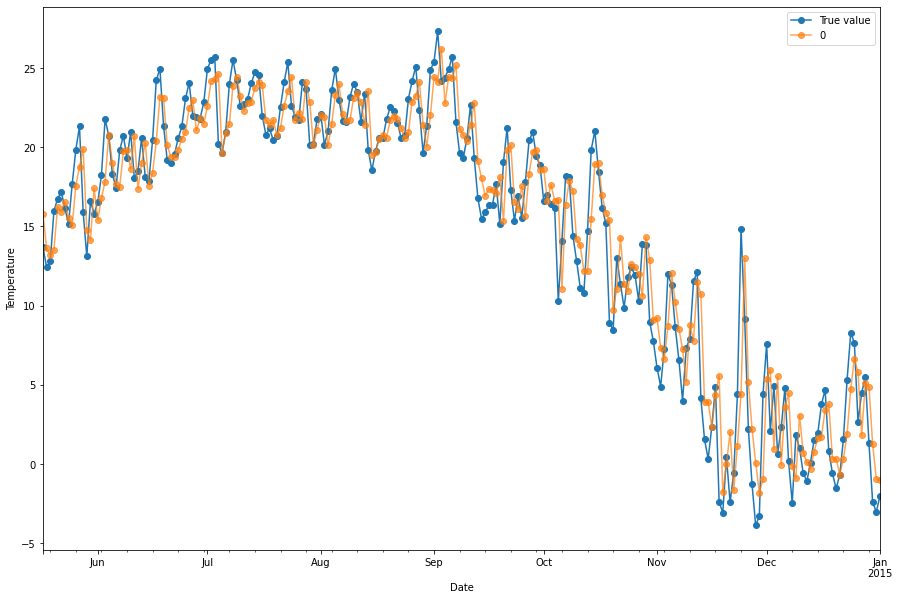

In [ ]:
plt.figure(figsize = (15,10))
ax = testdestand.plot(marker = 'o',label='True value')
ydestand.plot(marker = 'o',  label='Prediction',ax=ax, alpha=.7)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')


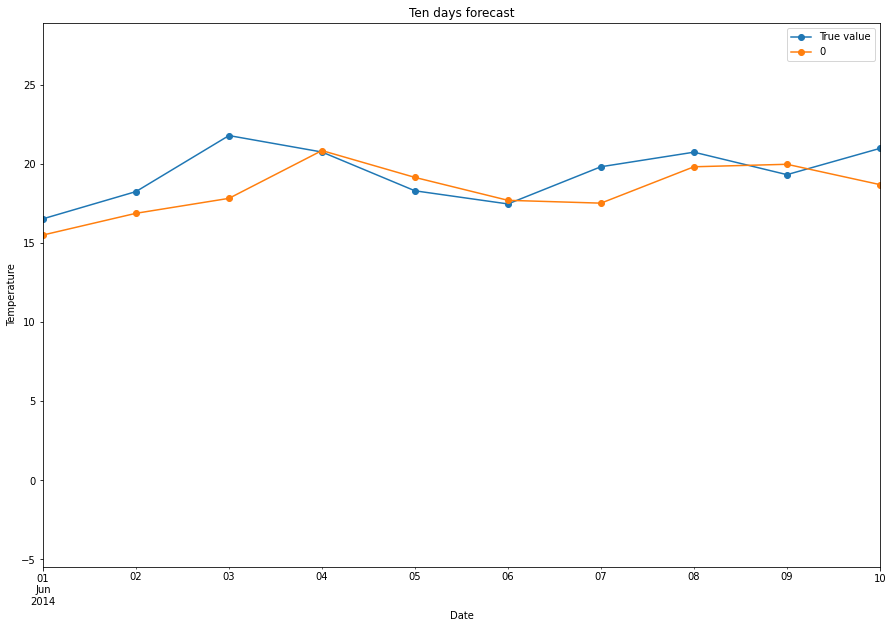

In [ ]:
plt.figure(figsize = (15,10))
ax = testdenorm.plot(marker='o',label='True value')
ydenorm.plot(ax=ax, marker='o',label='Prediction')
ax.axis(xmin='2014-06-01',xmax='2014-06-10')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Ten days forecast')
plt.legend()


**Conclusion for SARIMA model**

In conclusion looking at the MAAPE indicator the model implemented with normalized temperature present a better fit. So the normalization makes the model works better.

The forecasted data looks like that is one step behind the true value for all the SARIMA models.
It seems that models are making a persistence forecast: the input to the forecast (e.g. the observation at the previous time step) is predicted as the output.
Probably the chosen models cannot address my specific dataset.


In [ ]:
print('SARIMA')
print('MSE: {}'.format(round(mse_ar.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_ar.mean()))
print('SARIMA with normalized temperature')
print('MSE: {}'.format(round(mse_ar_n.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_ar_n.mean()))
print('SARIMA with standardize temperature ')
print('MSE: {}'.format(round(mse_ar_s.mean(), 4)))
print('MAAPE : {:.2%}'.format(maape_ar_s.mean()))

SARIMA
MSE: 7.7138
MAAPE: 41.35%
SARIMA with normalized temperature
MSE: 0.002
MAAPE: 5.82%
SARIMA with standardize temperature 
MSE: 0.0551
MAAPE : 27.78%


# **DNNRegressor - TensorFlow**
Neural networks have a powerful way of utilizing learning techniques based on both linear and non-linear operations.
In this project I will explore a supervised machine learning model. 
The accuracy is evaluated by using a cost ("loss") function, namely the sum of squared errors (SSE).


In [ ]:
import tensorflow as tf
#setting seed to ensure reproducibility
tf.random.set_seed(13)


I will use weather data on the prior three days and I will include the new features relative to these days as columns in the DataFrame. 
For each day and for a given feature I want find the value for that feature N days prior. For each value of N  I will make a new column for that feature representing the Nth prior day's measurement.
A reusable function will do this job and then in a loop (that loops over the features in the feature list and for N days 1 through 3) this function is called to add the derived features I want to evaluate for predicting temperatures.

In [ ]:
def derive_nth_day_feature(df, feature, N):
    # a list representing Nth prior measurements of feature
    nth_prior_measurements = df[feature].shift(periods=N)
    # make a new column name of feature_N and add to DataFrame
    col_name = f'{feature}_{N}'
    df[col_name] = nth_prior_measurements

In [ ]:
for feature in list(df_dnn):
  for N in range(1, 4):
    derive_nth_day_feature(df_dnn, feature, N)

df_dnn.head(10)

PREC_TOT  ...  ALLSKY_SFC_SWAVE_DWN_3
1983-07-01      0.02  ...                     NaN
1983-07-02      0.08  ...                     NaN
1983-07-03      0.11  ...                     NaN
1983-07-04      3.21  ...                    3.34
1983-07-05      4.44  ...                    6.22
1983-07-06      1.48  ...                    7.69
1983-07-07      0.00  ...                    5.60
1983-07-08      0.00  ...                    3.80
1983-07-09      0.00  ...                    5.91
1983-07-10      0.00  ...                    8.23

[10 rows x 60 columns]

In [ ]:
#remove the first 3 rows with the Nan value
df_dnn = df_dnn[df_dnn.index >= '1983-07-04']
df_dnn.head(5)

PREC_TOT  ...  ALLSKY_SFC_SWAVE_DWN_3
1983-07-04      3.21  ...                    3.34
1983-07-05      4.44  ...                    6.22
1983-07-06      1.48  ...                    7.69
1983-07-07      0.00  ...                    5.60
1983-07-08      0.00  ...                    3.80

[5 rows x 60 columns]

As I'm trying to predict the future it's obvious that we can not have data about the future in the feature set (X), so the T_2M column is going to be removed and put as target (y).

In [ ]:
#tensorflow doesn't support the datetime DType so I need to convert it to an integer
df3 = df_dnn.reset_index(drop=True)

# X will be a pandas dataframe of all columns except T_2M
X = df3[[col for col in df3.columns if col != 'T_2M']]
#the maximum and the minimun temperature column are removed because they represent the 'future' that it's going to be predicted
del X['T_2M_MAX']
del X['T_2M_MIN']

# y will be a pandas series of the meantempm
y = df3['T_2M']


In [ ]:
X.head(5)

PREC_TOT  SURFACE_PRES  ...  ALLSKY_SFC_SWAVE_DWN_2  ALLSKY_SFC_SWAVE_DWN_3
0      3.21        100.38  ...                    6.22                    3.34
1      4.44         99.87  ...                    7.69                    6.22
2      1.48        100.30  ...                    5.60                    7.69
3      0.00        101.13  ...                    3.80                    5.60
4      0.00        101.08  ...                    5.91                    3.80

[5 rows x 57 columns]

As with all supervised machine learning models, the dataset will be divided into training and testing sets and a  validation set is also used. For the training there will be the 80 % of the data and for the testing and validation set there will be 10% of the remaining data each. In time series as order matters the split of data it has been taken not breking the order.



In [ ]:
# split data into training set and a temporary set 
n_of_split = int(len(X)*0.8)
X_train, X_tmp = np.split(X, [n_of_split])
y_train, y_tmp = np.split(y, [n_of_split])


In [ ]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
n_of_split2 = int(len(y_tmp)*0.5)
X_test, X_val = np.split(X_tmp, [n_of_split2])
y_test, y_val = np.split(y_tmp, [n_of_split2])


print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   9204, Training features   57
Validation instances 1151, Validation features 57
Testing instances    1150, Testing features    57


The first step to take when building a neural network model is to instantiate the **tf.estimator.DNNRegressor()** class. The class constructor parameters that will be used are the following:

* **feature_columns**: An iterable containing all the feature columns used by the model. All items in the set should be instances of classes derived from FeatureColumn.

* **hidden_units**: Iterable of number hidden units per layer. All layers are fully connected. 

* **optimizer**: An instance of tf.keras.optimizers used to train the model, its default is the AdaGrad optimizer but I will use Adam since after some tests it turned to be more computationally efficient.

* **activation_fn**: Activation function applied to each layer to introduce non-linearity into the network, the default is Relu.

* **model_dir**: Directory to save model parameters, graph and etc. This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.

Firstly a list of numeric feature columns is defined with the **tf.feature_column.numeric_column()** function which returns a FeatureColumn instance for numeric, continuous-valued features.

In [ ]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

Then a neural network two layers deep, with a width of 57 and 19 nodes, is 
defined. The model data is stored in a directory.

In [ ]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols, hidden_units=[57, 19], optimizer = 'Adam', model_dir='tf_model5')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_model5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


To feed data into the neural network during the training and testing phases, I defined a reusable function, input_fn(). Since data is in a pandas data structure I'm going to use the **tf.compat.v1.estimator.inputs.pandas_input_fn()**.

In [ ]:
def input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=236): 
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, #x are the input features to be fed into one of the three DNNRegressor interface methods (train, evaluate, and predict)
                                               y=y, #y is the target values of X
                                               num_epochs=num_epochs, #an epoch occurs when the algorithm executes over the entire dataset one time.
                                               shuffle=shuffle, #an optional parameter that specifies whether to randomly select a batch of the dataset each time the algorithm executes
                                               batch_size=batch_size) #number of samples to include each time the algorithm executes

With the input function defined the neural network can be trained on the training dataset.
A simple training loop to train the model on the training data is defined and the evaluation data are evaluated periodically in order to build the evaluation loss.
I choose the number of steps considering the ratio between the train set size and the batchsize (9204/236 = 39) in such a way an epoch is accomplished every 39 steps.
I left the shuffle parameter equal to its default value of True so that while training, the data is selected randomly to avoid any sequential relationships in the data. 

In [ ]:
evaluations = []
STEPS = 39 
for i in range(70):
    regressor.train(input_fn=input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=input_fn(X_val, y_val,num_epochs=1,shuffle=False)))
    


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSav

In [ ]:
#all the parameters saved in the array after the evaluation
evaluations[0]

{'average_loss': 24.74934,
 'global_step': 39,
 'label/mean': 10.737071,
 'loss': 24.658976,
 'prediction/mean': 10.696398}

Now that I have a collection of evaluations for each of the iterations let's plot them as a function of training steps to ensure we have not over-trained the model.

Text(0, 0.5, 'Loss (SSE)')

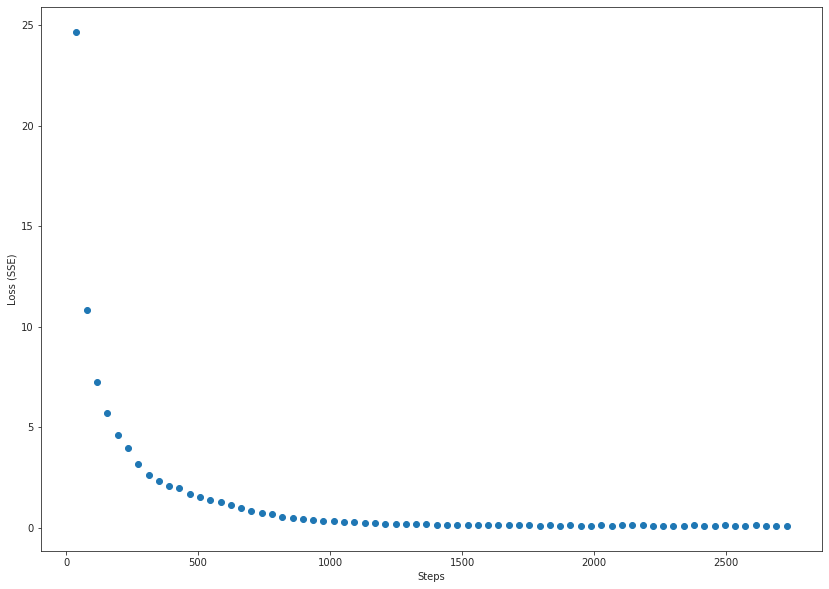

In [ ]:
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Steps')
plt.ylabel('Loss (SSE)')


From the plot above it looks like after the iterations the model is not overfitting because the evaluation losses never exhibit a significant change in direction toward an increasing value. Now I can safely move on to making predictions based off my remaining test dataset.

In the predict() object the shuffle is set to  false so that it is sequentially feeding all the data to test against.


In [ ]:
pred = regressor.predict(input_fn= input_fn(X_test,num_epochs=1, shuffle=False))
#select only the predicted values
predictions = np.array([p['predictions'][0] for p in pred])


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_model5/model.ckpt-2730
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
# Compute the mean square error
mse_dnn = ((predictions - y_test) ** 2)
#Calculate the Mean Arctangent Absolute Percentage Error
maape_dnn = (np.arctan(np.abs((y_test-predictions)/y_test)))

print('DNN')
print('MSE: {}'.format(round(mse_dnn.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_dnn.mean()))


DNN
MSE: 0.1119
MAAPE: 6.59%


In [ ]:
#reset the index in order to have the true values of test set not shifted
y_t = y_test.reset_index(drop=True)

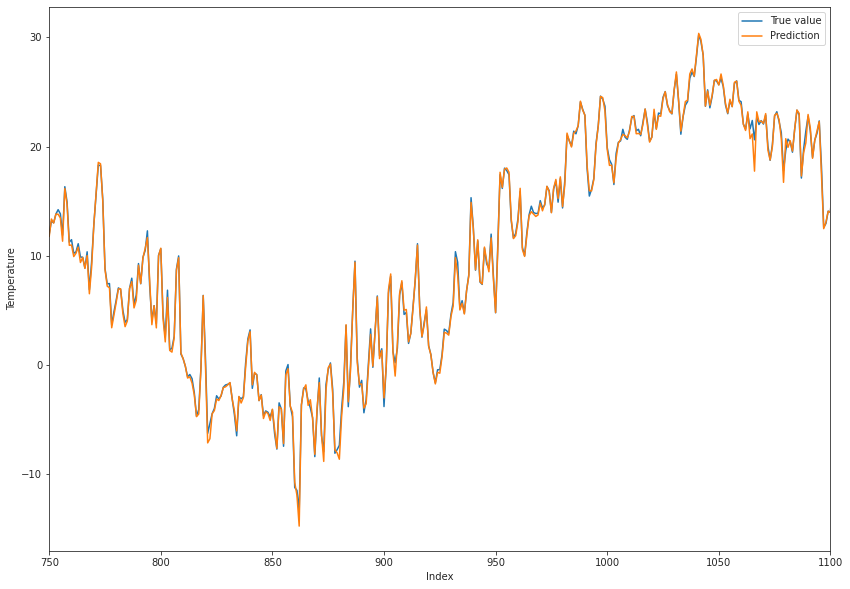

In [ ]:
from matplotlib import pyplot
pyplot.plot(y_t, label='True value')
pyplot.plot(predictions, label='Prediction')
pyplot.xlim(right= 1100)
pyplot.xlim(left= 750)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

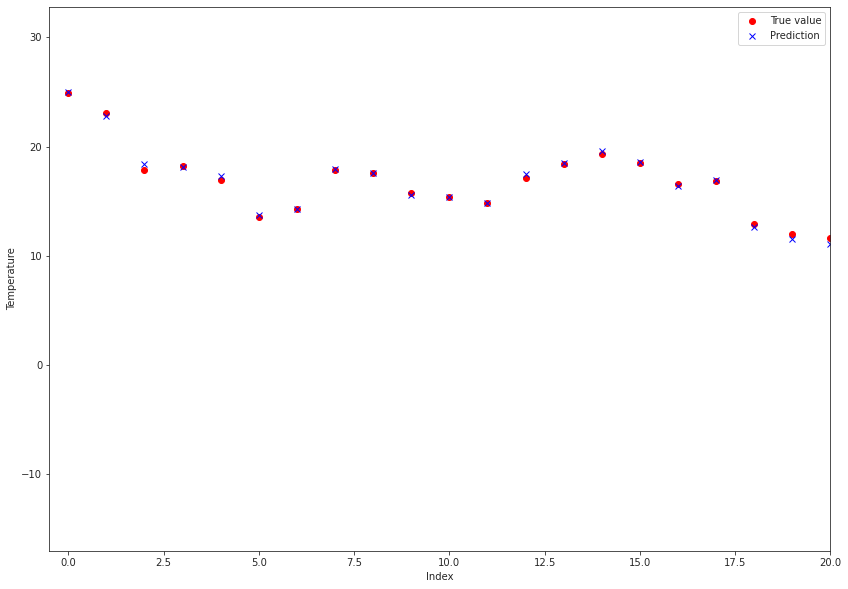

In [ ]:
from matplotlib import pyplot
pyplot.plot(y_t,'ro', label='True value')
pyplot.plot(predictions,'bx', label='Prediction')
pyplot.xlim(right= 20)
pyplot.xlim(left= -0.5)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

From plots, MSE value and MAAPE value it can be seen that model obtained is a very good one.

 **Normalization and standardization of the dataset**

In [ ]:
#normalization
df3_norm=(df3-df3.min())/(df3.max()-df3.min())

#standardization 
df3_stand = (df3 - df3.mean())/df3.std()

In [ ]:
# X will be a pandas dataframe of all columns except T_2M
X_norm = df3_norm[[col for col in df3_norm.columns if col != 'T_2M']]
X_stand = df3_stand[[col for col in df3_stand.columns if col != 'T_2M']]

#the maximum and the minimun temperature column are removed because they represent the 'future' that it's going to be predicted
del X_norm['T_2M_MAX']
del X_norm['T_2M_MIN']
del X_stand['T_2M_MAX']
del X_stand['T_2M_MIN']

# y will be a pandas series of the temperature
y_norm = df3_norm['T_2M']
y_stand = df3_stand['T_2M']

In [ ]:
# split data into training set and a temporary set not breaking the time series
n_of_split = int(len(X)*0.8)
X_train_norm, X_tmp_n = np.split(X_norm, [n_of_split])
y_train_norm, y_tmp_n = np.split(y_norm, [n_of_split])
X_train_stand, X_tmp_s = np.split(X_stand, [n_of_split])
y_train_stand, y_tmp_s = np.split(y_stand, [n_of_split])

In [ ]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
n_of_split2 = int(len(y_tmp)*0.5)
X_test_norm, X_val_norm = np.split(X_tmp_n, [n_of_split2])
y_test_norm, y_val_norm = np.split(y_tmp_n, [n_of_split2])
X_test_stand, X_val_stand = np.split(X_tmp_s, [n_of_split2])
y_test_stand, y_val_stand = np.split(y_tmp_s, [n_of_split2])

print("Norm: Training instances   {}, Training features   {}".format(X_train_norm.shape[0], X_train_norm.shape[1]))
print("Norm: Validation instances {}, Validation features {}".format(X_val_norm.shape[0], X_val_norm.shape[1]))
print("Norm: Testing instances    {}, Testing features    {}".format(X_test_norm.shape[0], X_test_norm.shape[1]))
print("Stand: Training instances   {}, Training features   {}".format(X_train_stand.shape[0], X_train_stand.shape[1]))
print("Stand: Validation instances {}, Validation features {}".format(X_val_stand.shape[0], X_val_stand.shape[1]))
print("Stand: Testing instances    {}, Testing features    {}".format(X_test_stand.shape[0], X_test_stand.shape[1]))

Norm: Training instances   9204, Training features   57
Norm: Validation instances 1151, Validation features 57
Norm: Testing instances    1150, Testing features    57
Stand: Training instances   9204, Training features   57
Stand: Validation instances 1151, Validation features 57
Stand: Testing instances    1150, Testing features    57


In [ ]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_norm.columns]

In [ ]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols, hidden_units=[57, 19], optimizer = 'Adam', model_dir='tf_model_norm')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_model_norm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=236): 
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, #x are the input features to be fed into one of the three DNNRegressor interface methods (train, evaluate, and predict)
                                               y=y, #y is the target values of X
                                               num_epochs=num_epochs, #an epoch occurs when the algorithm executes over the entire dataset one time.
                                               shuffle=shuffle, #an optional parameter that specifies whether to randomly select a batch of the dataset each time the algorithm executes
                                               batch_size=batch_size) #number of samples to include each time the algorithm executes

In [ ]:
evaluations_norm = []
STEPS = 39 
for i in range(100):
    regressor.train(input_fn=input_fn(X_train_norm, y=y_train_norm), steps=STEPS)
    evaluations_norm.append(regressor.evaluate(input_fn=input_fn(X_val_norm, y_val_norm,num_epochs=1,shuffle=False)))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into tf_model_norm/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.19028296, step = 0
INFO:t

Text(0, 0.5, 'Loss (SSE)')

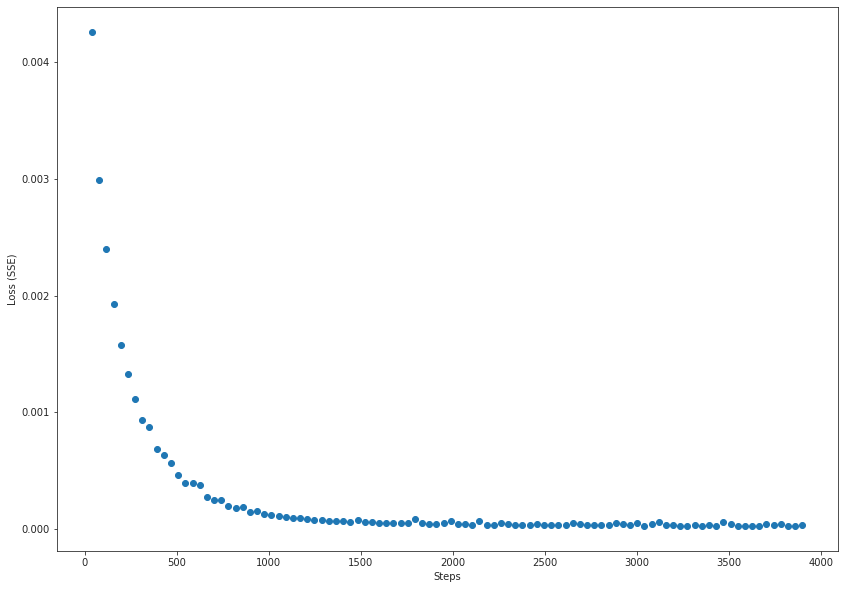

In [ ]:
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations_norm]
training_steps = [ev['global_step'] for ev in evaluations_norm]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Steps')
plt.ylabel('Loss (SSE)')


In [ ]:
y_n = y_test_norm.reset_index(drop=True) #not shifted test set

In [ ]:
pred = regressor.predict(input_fn= input_fn(X_test_norm, num_epochs=1, shuffle=False))
predictions_norm = np.array([p['predictions'][0] for p in pred])


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_model_norm/model.ckpt-3900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
# Compute the mean square error
mse_dnn_norm = ((predictions_norm - y_test_norm) ** 2)
#Calculate the Mean Arctangent Absolute Percentage Error
maape_dnn_norm = (np.arctan(np.abs((y_test_norm-predictions_norm)/y_test_norm)))

print('DNN with normalized data')
print('MSE: {}'.format(round(mse_dnn_norm.mean(), 6)))
print('MAAPE: {:.2%}'.format(maape_dnn_norm.mean()))

DNN with normalized data
MSE: 3.5e-05
MAAPE: 0.95%


In [ ]:
#denormalization
ydenorm = (predictions_norm*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()
testdenorm = (y_n*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()

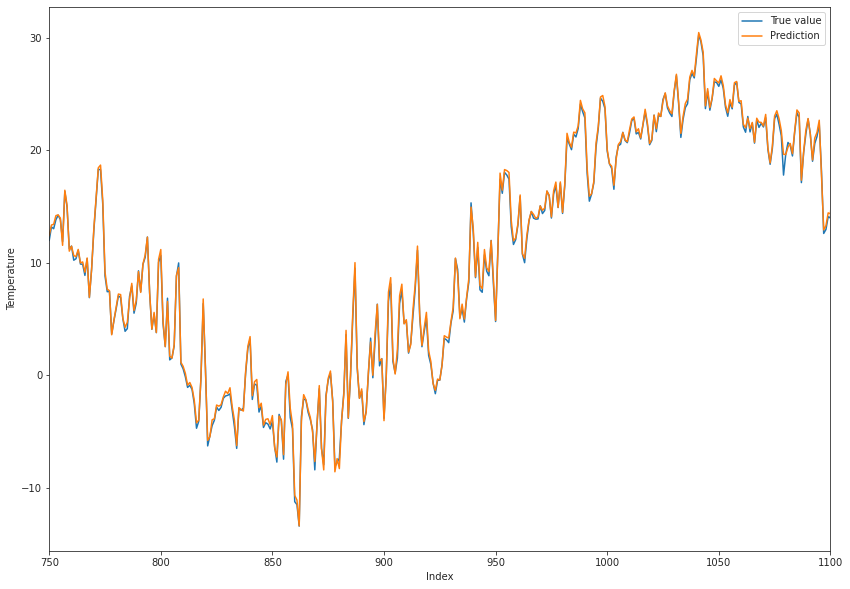

In [ ]:
from matplotlib import pyplot
pyplot.plot(testdenorm, label='True value')
pyplot.plot(ydenorm, label='Prediction')
pyplot.xlim(right=1100 )
pyplot.xlim(left=750)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

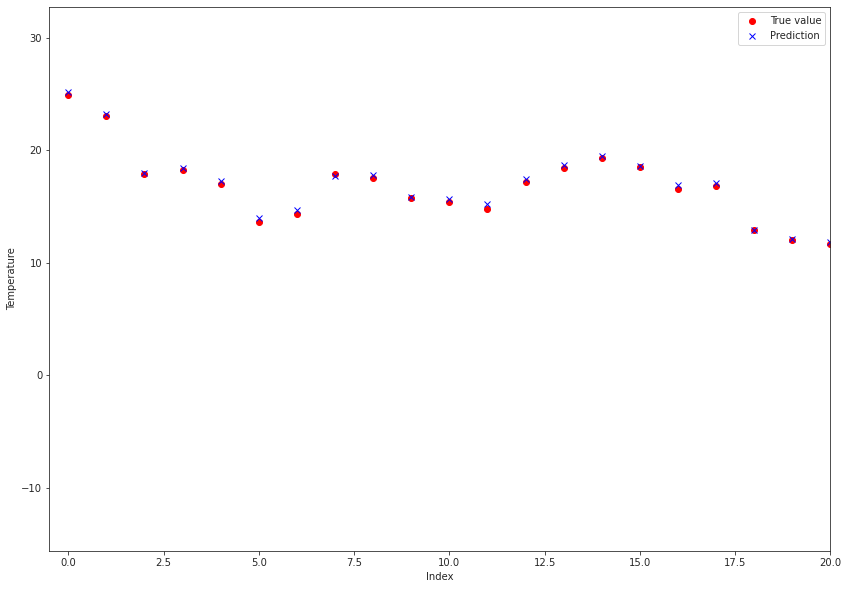

In [ ]:
from matplotlib import pyplot
pyplot.plot(testdenorm,'ro', label='True value')
pyplot.plot(ydenorm,'bx', label='Prediction')
pyplot.xlim(right= 20)
pyplot.xlim(left= -0.5)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

 **Standardization of the dataset**

In [ ]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_stand.columns]

In [ ]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols, hidden_units=[57, 19], optimizer = 'Adam',model_dir='tf_model_s')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_model_s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=354):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, #x are the input features to be fed into one of the three DNNRegressor interface methods (train, evaluate, and predict)
                                               y=y, #y is the target values of X
                                               num_epochs=num_epochs, #an epoch occurs when the algorithm executes over the entire dataset one time.
                                               shuffle=shuffle, #an optional parameter that specifies whether to randomly select a batch of the dataset each time the algorithm executes
                                               batch_size=batch_size) #number of samples to include each time the algorithm executes

In [ ]:
evaluations_stand = []
STEPS = 26 
for i in range(100):
    regressor.train(input_fn=input_fn(X_train_stand, y=y_train_stand), steps=STEPS)
    evaluations_stand.append(regressor.evaluate(input_fn=input_fn(X_val_stand, y_val_stand, num_epochs=1, shuffle=False)))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into tf_model_s/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1862622, step = 0
INFO:tenso

Text(0, 0.5, 'Loss (SSE)')

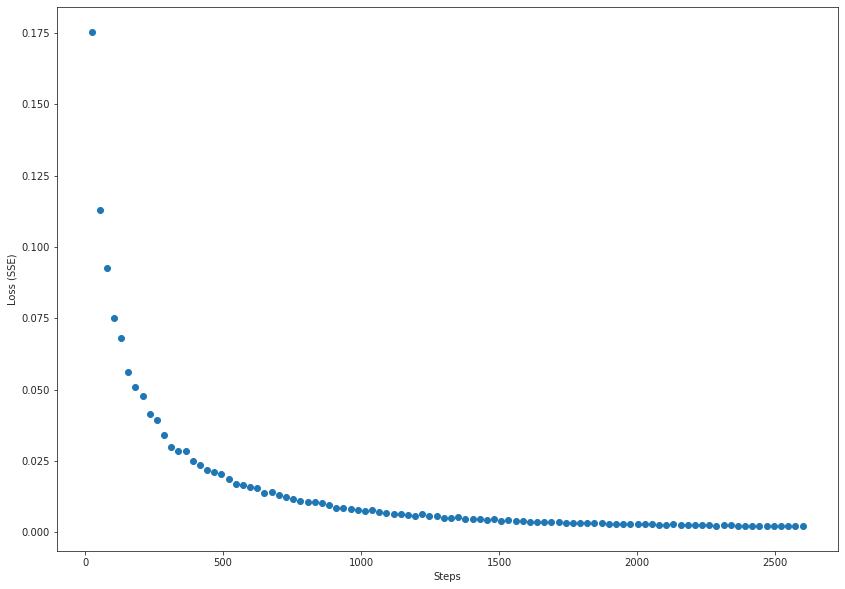

In [ ]:
plt.rcParams['figure.figsize'] = [14, 10]
loss_values = [ev['loss'] for ev in evaluations_stand]
training_steps = [ev['global_step'] for ev in evaluations_stand]
plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Steps')
plt.ylabel('Loss (SSE)')


In [ ]:
pred = regressor.predict(input_fn= input_fn(X_test_stand,num_epochs=1,shuffle=False))
predictions_stand = np.array([p['predictions'][0] for p in pred])


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_model_s/model.ckpt-2600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
# Compute the mean square error
mse_dnn_stand = ((predictions_stand - y_test_stand) ** 2)

#Calculate the Mean Arctangent Absolute Percentage Error
maape_dnn_stand = (np.arctan(np.abs((y_test_stand-predictions_stand)/y_test_stand)))

print('DNN with standardize data')
print('MSE: {}'.format(round(mse_dnn_stand.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_dnn_stand.mean()))

DNN with standardize data
MSE: 0.0026
MAAPE: 11.05%


In [ ]:
y_s = y_test_stand.reset_index(drop=True) #not shifted test set

In [ ]:
#de-standardize 
ydestand = predictions_stand*df2.T_2M.std()+df2.T_2M.mean()
testdestand = y_s*df2.T_2M.std()+df2.T_2M.mean()

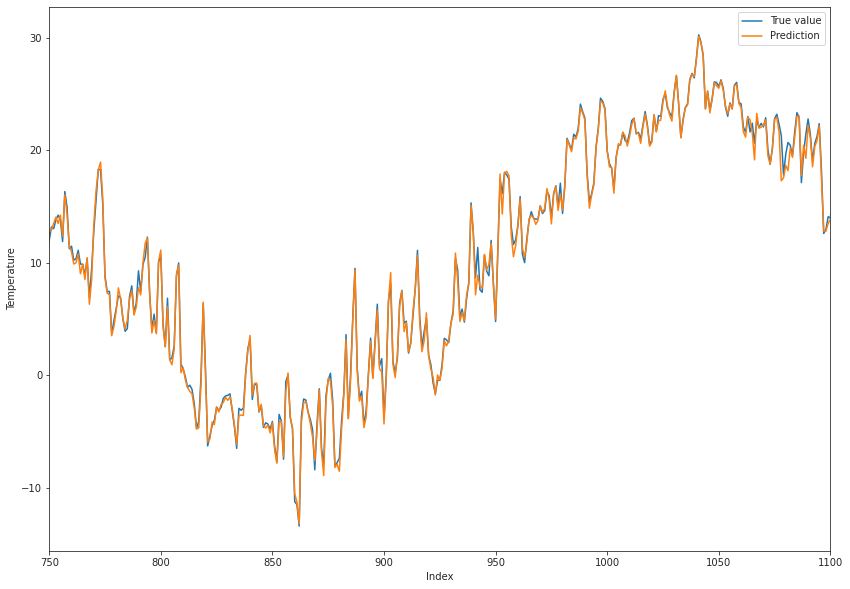

In [ ]:
from matplotlib import pyplot
pyplot.plot(testdestand, label='True value')
pyplot.plot(ydestand, label='Prediction')
pyplot.xlim(right= 1100)
pyplot.xlim(left= 750)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

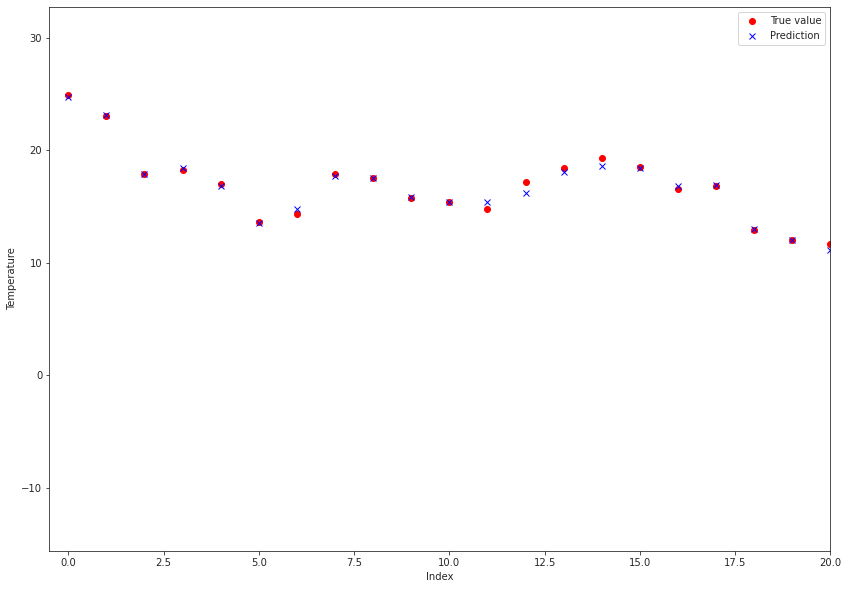

In [ ]:
pyplot.plot(testdestand,'ro', label='True value')
pyplot.plot(ydestand,'bx', label='Prediction')
pyplot.xlim(right= 20)
pyplot.xlim(left= -0.5)
pyplot.xlabel('Index')
pyplot.ylabel('Temperature')
pyplot.legend()

**Conclusion for DNN Regressor model**

All the three loss functions shows that the models are not overfitting. 
Looking to the MAAPE indicator the model with normalized data results to be better than the others.

In [ ]:
print('DNN ')
print('MSE: {}'.format(round(mse_dnn.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_dnn.mean()))
print('DNN with normalized data')
print('MSE: {}'.format(round(mse_dnn_norm.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_dnn_norm.mean()))
print('DNN with standardized data')
print('MSE: {}'.format(round(mse_dnn_stand.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_dnn_stand.mean()))

DNN 
MSE: 0.1119
MAAPE: 6.59%
DNN with normalized data
MSE: 0.0
MAAPE: 0.95%
DNN with standardized data
MSE: 0.0026
MAAPE: 11.05%


# **LSTM Bidirectional**

Before starting to implement the model it's necessary to do some data preprocessing: I need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job and moreover returns the sequences in the shape (samples, time_steps, features) necessary to implement an LSTM model.

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
# X will be a pandas dataframe of all columns except T_2M
X = df_lstm[[col for col in df_lstm.columns if col != 'T_2M']]
#the maximum and the minimun temperature column are removed because they represent the 'future' that it's going to be predicted
del X['T_2M_MAX']
del X['T_2M_MIN']

# y will be a pandas series of theT_2M
y = df_lstm['T_2M']

The data are splitted in a training and a test set with 80% and 20% of the data respectively.

In [ ]:
# split data into training set and a test set 
n_of_split = int(len(X)*0.8)
X_train, X_test = np.split(X, [n_of_split])
y_train, y_test = np.split(y, [n_of_split])

print("X_train shape:",(X_train.shape))
print("X_test shape:",(X_test.shape))
print("y_train shape:",(y_train.shape))
print("y_test shape:",(y_test.shape))


X_train shape: (9206, 12)
X_test shape: (2302, 12)
y_train shape: (9206,)
y_test shape: (2302,)


In [ ]:
time_steps = 3

# reshape to [samples, time_steps, n_features] with the function 'create_dataset'
X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print("Train:" ,X_train.shape, y_train.shape)
print("Test:",X_test.shape, y_test.shape)

Train: (9203, 3, 12) (9203,)
Test: (2299, 3, 12) (2299,)


Now it's time to modeling.
I will use the LSTM layer in a sequential model to make predictions. 
The first layer is a Bidirectional LSTM with 36 units; I have chosen a Bidirectional one in order to make the model learn the input sequence both forward and backwards and concatenate both interpretations.
Firstly I have put also a dropout layer but the model was underfitting so I removed it; moreover the model works better witouth any other layer.
I will use the Mean Absolute Error (MAE) loss function and the Adam version of stochastic gradient descent.


In [ ]:
from keras import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=36,  input_shape=(X_train.shape[1], X_train.shape[2]))))
model_lstm.add(Dense(units=1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


Now it's time to train the model.
The model will be fit for 50 training epochs with a batch size of 60.
I will keep track of both the training and validation loss during training by setting the validation_split argument in the fit() function. At the end of the run both the training and validation loss are plotted.
The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters). 

In [ ]:
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=60, validation_split=0.2, shuffle=False) 

Train on 7362 samples, validate on 1841 samples
Epoch 1/50
7362/7362 [==============================] - 1s 182us/step - loss: 141.6035 - val_loss: 96.7314
Epoch 2/50
7362/7362 [==============================] - 1s 80us/step - loss: 65.0798 - val_loss: 49.6470
Epoch 3/50
7362/7362 [==============================] - 1s 78us/step - loss: 36.2153 - val_loss: 29.8822
Epoch 4/50
7362/7362 [==============================] - 1s 83us/step - loss: 22.2399 - val_loss: 19.4089
Epoch 5/50
7362/7362 [==============================] - 1s 80us/step - loss: 15.5936 - val_loss: 13.9299
Epoch 6/50
7362/7362 [==============================] - 1s 79us/step - loss: 12.1634 - val_loss: 11.0835
Epoch 7/50
7362/7362 [==============================] - 1s 79us/step - loss: 10.1176 - val_loss: 9.2525
Epoch 8/50
7362/7362 [==============================] - 1s 78us/step - loss: 8.9304 - val_loss: 8.0861
Epoch 9/50
7362/7362 [==============================] - 1s 79us/step - loss: 8.2712 - val_loss: 7.5796
Epoch 10/5

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure(figsize=(14,10))
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()


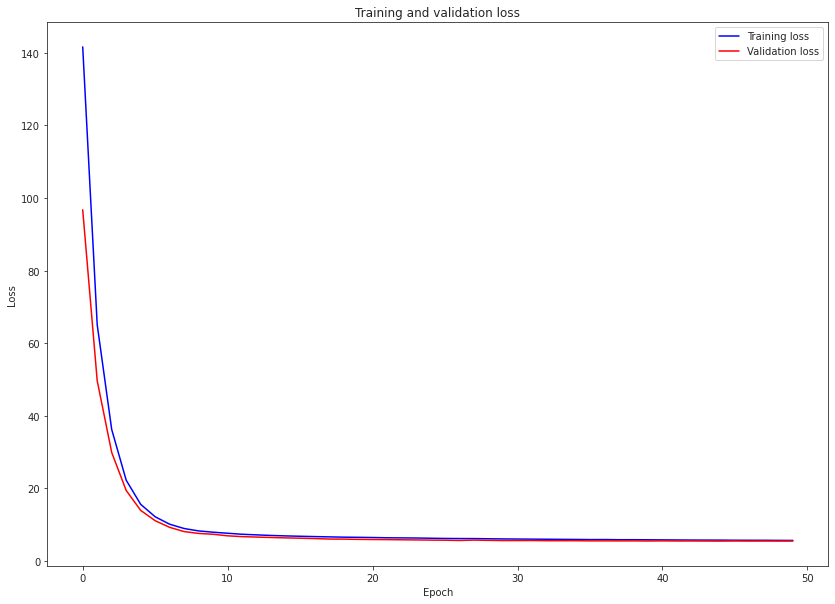

In [ ]:
plot_train_history(history,'Training and validation loss')

The training and the validation loss are almost parallel and very close so the model is not underfitting or overfitting and I can make predictions.

In [ ]:
y_pred = model_lstm.predict(X_test)

# Compute the mean square error
mse_lstm = ((y_pred[:,0] - y_test) ** 2)

#Calculate the Mean Arctangent Absolute Percentage Error
maape_lstm = (np.arctan(np.abs((y_test-y_pred[:,0])/(y_test))))

print('LSTM')
print('MSE: {}'.format(round(mse_lstm.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm.mean()))

LSTM
MSE: 5.7081
MAAPE: 30.08%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


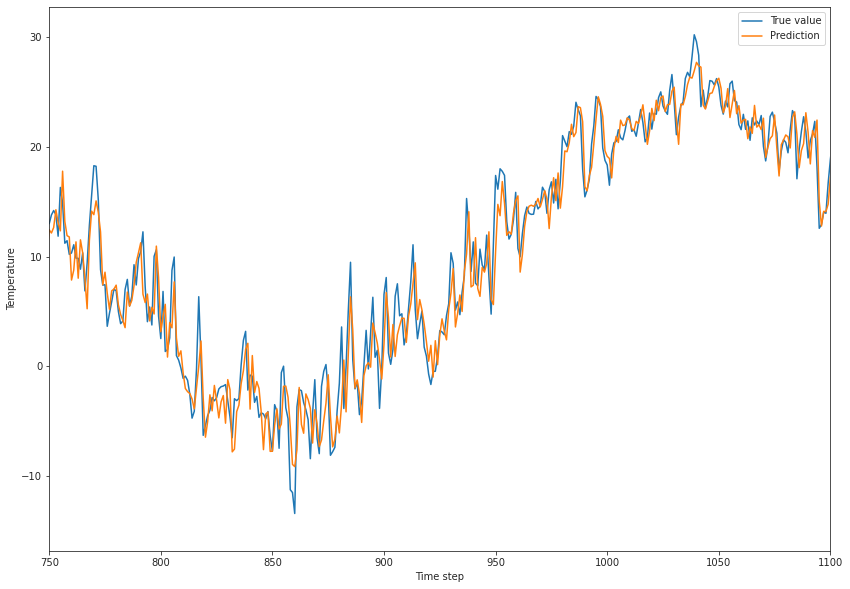

In [ ]:
pyplot.plot(y_test, label='True value')
pyplot.plot(y_pred, label='Prediction')
pyplot.xlim(right=1100)
pyplot.xlim(left= 750)
pyplot.xlabel('Time step')
pyplot.ylabel('Temperature')
pyplot.legend()

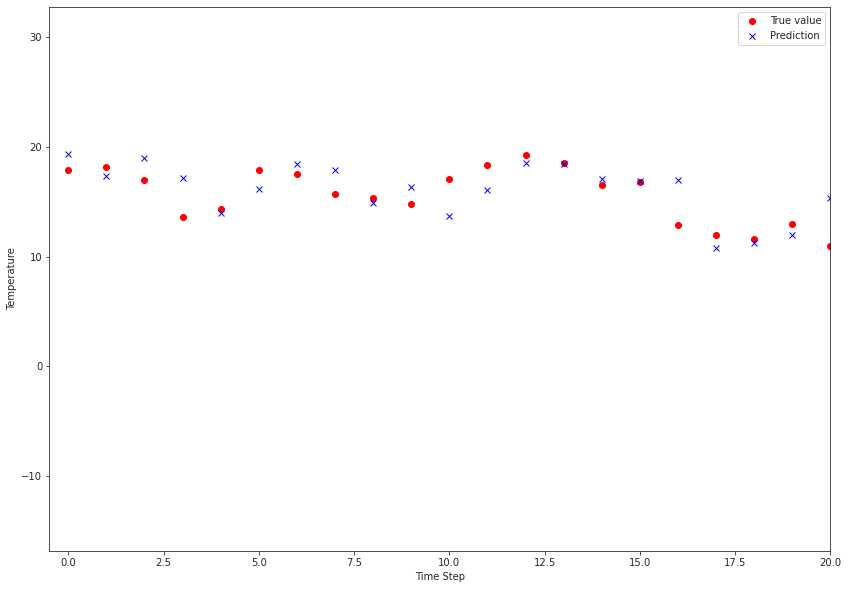

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(y_test, 'ro', label="True value")
plt.plot(y_pred, 'bx', label="Prediction")
plt.ylabel('Temperature')
plt.xlabel('Time Step')
plt.xlim(-0.5,20)
plt.legend() 

**Normalization and standardization of the dataset**

In [ ]:
#normalization
df_lstm_norm=(df_lstm-df_lstm.min())/(df_lstm.max()-df_lstm.min())

#standardization 
df_lstm_stand = (df_lstm - df_lstm.mean())/df_lstm.std()


In [ ]:
# X will be a pandas dataframe of all columns except T_2M
X_norm = df_lstm_norm[[col for col in df_lstm_norm.columns if col != 'T_2M']]
#the maximum and the minimun temperature column are removed because they represent the 'future' that it's going to be predicted
del X_norm['T_2M_MAX']
del X_norm['T_2M_MIN']

# y will be a pandas series of theT_2M
y_norm = df_lstm_norm['T_2M']

In [ ]:
# split data into training set and a test set 
n_of_split = int(len(X)*0.8)
X_train_n, X_test_n = np.split(X_norm, [n_of_split])
y_train_n, y_test_n = np.split(y_norm, [n_of_split])

print("X_train shape:",(X_train_n.shape))
print("X_test shape:",(X_test_n.shape))
print("y_train shape:",(y_train_n.shape))
print("y_test shape:",(y_test_n.shape))


X_train shape: (9206, 12)
X_test shape: (2302, 12)
y_train shape: (9206,)
y_test shape: (2302,)


In [ ]:
time_steps = 3

# reshape to [samples, time_steps, n_features]

X_train_n, y_train_n = create_dataset(X_train_n, y_train_n, time_steps)
X_test_n, y_test_n = create_dataset(X_test_n, y_test_n, time_steps)


print("Train norm:" ,X_train_n.shape, y_train_n.shape)
print("Test norm:",X_test_n.shape, y_test_n.shape)

Train norm: (9203, 3, 12) (9203,)
Test norm: (2299, 3, 12) (2299,)


In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=36, input_shape=(X_train_n.shape[1], X_train_n.shape[2])))) 
model_lstm.add(Dense(units=1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history_n = model_lstm.fit(X_train_n, y_train_n, epochs=50, batch_size=78, validation_split=0.2, shuffle=False)


Train on 7362 samples, validate on 1841 samples
Epoch 1/50
7362/7362 [==============================] - 1s 151us/step - loss: 0.0564 - val_loss: 0.0081
Epoch 2/50
7362/7362 [==============================] - 0s 63us/step - loss: 0.0057 - val_loss: 0.0048
Epoch 3/50
7362/7362 [==============================] - 0s 65us/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/50
7362/7362 [==============================] - 0s 63us/step - loss: 0.0040 - val_loss: 0.0036
Epoch 5/50
7362/7362 [==============================] - 0s 66us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 6/50
7362/7362 [==============================] - 0s 64us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/50
7362/7362 [==============================] - 0s 65us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/50
7362/7362 [==============================] - 0s 64us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 9/50
7362/7362 [==============================] - 0s 66us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
7362/7362 [=

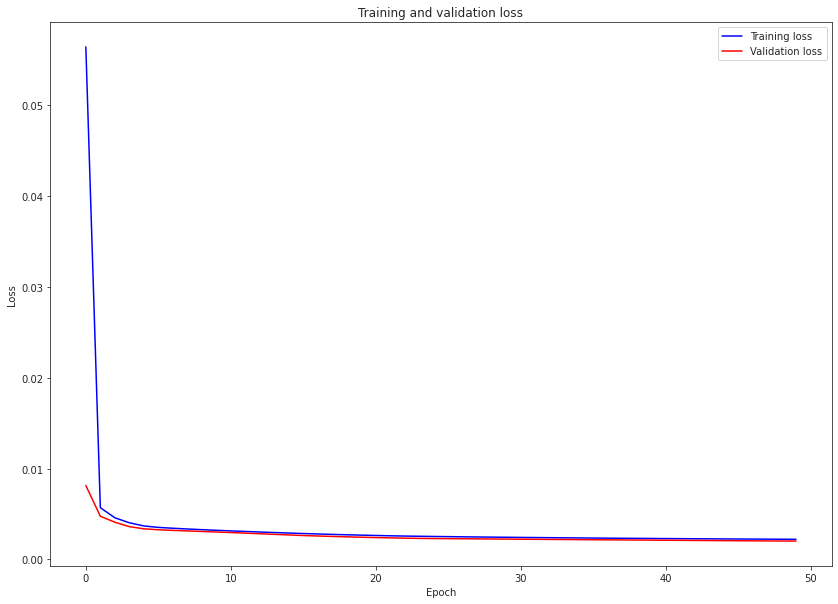

In [ ]:
plot_train_history(history_n,'Training and validation loss')

Also for the normalized data the training and the validation loss function are very close to each other and parallel, so I can continue to the prediction part of the model.

In [ ]:
y_pred_n = model_lstm.predict(X_test_n)

# Compute the mean square error
mse_lstm_n = ((y_pred_n[:,0] - y_test_n) ** 2)

#Calculate the Mean Arctangent Absolute Percentage Error
maape_lstm_n= (np.arctan(np.abs((y_test_n-y_pred_n[:,0])/(y_test_n))))

print('LSTM with normalized data')
print('MSE: {}'.format(round(mse_lstm_n.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm_n.mean()))

LSTM with normalized data
MSE: 0.0022
MAAPE: 7.27%


In [ ]:
#denormalization
pred_denorm = (y_pred_n*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()
test_denorm = (y_test_n*(df2.T_2M.max()-df2.T_2M.min()))+df2.T_2M.min()

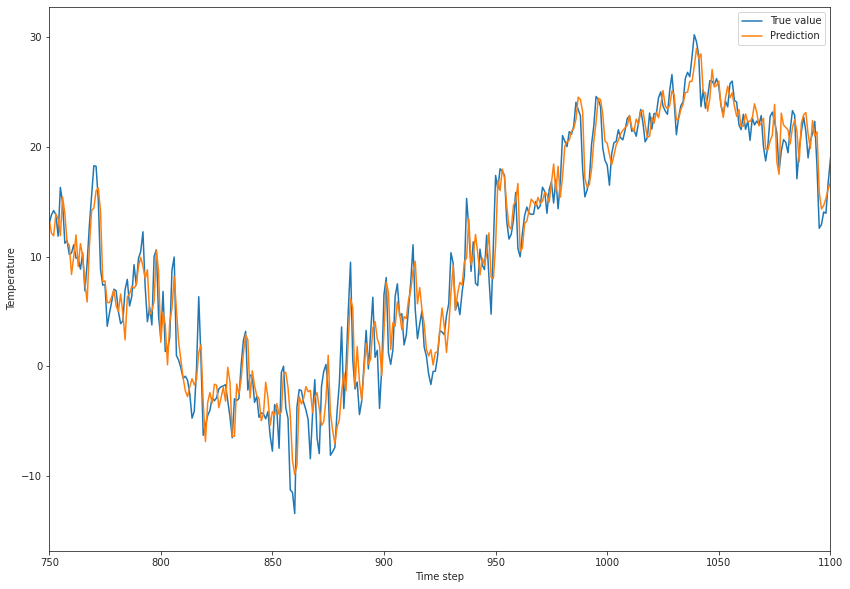

In [ ]:
pyplot.plot(test_denorm, label='True value')
pyplot.plot(pred_denorm, label='Prediction')
pyplot.xlim(right=1100)
pyplot.xlim(left= 750)
pyplot.xlabel('Time step')
pyplot.ylabel('Temperature')
pyplot.legend()

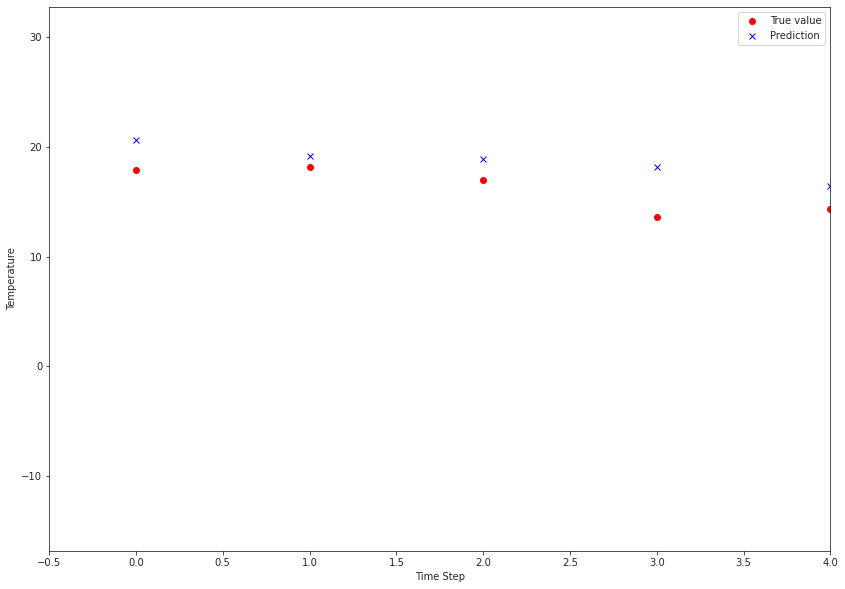

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(test_denorm, 'ro', label="True value")
plt.plot(pred_denorm, 'bx', label="Prediction")
plt.ylabel('Temperature')
plt.xlabel('Time Step')
plt.xlim(-0.5,4)
plt.legend() 

In [ ]:
# X will be a pandas dataframe of all columns except T_2M
X_stand = df_lstm_stand[[col for col in df_lstm_stand.columns if col != 'T_2M']]
#the maximum and the minimun temperature column are removed because they represent the 'future' that it's going to be predicted
del X_stand['T_2M_MAX']
del X_stand['T_2M_MIN']

# y will be a pandas series of theT_2M
y_stand = df_lstm_stand['T_2M']

In [ ]:
# split data into training set and a test set 
n_of_split = int(len(X)*0.8)
X_train_s, X_test_s = np.split(X_stand, [n_of_split])
y_train_s, y_test_s = np.split(y_stand, [n_of_split])

print("X_train shape:",(X_train_s.shape))
print("X_test shape:",(X_test_s.shape))
print("y_train shape:",(y_train_s.shape))
print("y_test shape:",(y_test_s.shape))


X_train shape: (9206, 12)
X_test shape: (2302, 12)
y_train shape: (9206,)
y_test shape: (2302,)


In [ ]:
time_steps = 3

# reshape to [samples, time_steps, n_features]

X_train_s, y_train_s = create_dataset(X_train_s, y_train_s, time_steps)
X_test_s, y_test_s = create_dataset(X_test_s, y_test_s, time_steps)


print("Train:" ,X_train_s.shape, y_train_s.shape)
print("Test:",X_test_s.shape, y_test_s.shape)

Train: (9203, 3, 12) (9203,)
Test: (2299, 3, 12) (2299,)


For the standardized dataset in the model is also implemented the dropout layer because the model was overfitting.

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=57, input_shape=(X_train_s.shape[1], X_train_s.shape[2]))))
model_lstm.add(Dropout(0.15))
model_lstm.add(Dense(units=1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history_s = model_lstm.fit(X_train_s, y_train_s, epochs=50, batch_size=78, validation_split=0.2, shuffle=False)


Train on 7362 samples, validate on 1841 samples
Epoch 1/50
7362/7362 [==============================] - 1s 171us/step - loss: 0.2209 - val_loss: 0.0881
Epoch 2/50
7362/7362 [==============================] - 1s 86us/step - loss: 0.0961 - val_loss: 0.0775
Epoch 3/50
7362/7362 [==============================] - 1s 85us/step - loss: 0.0868 - val_loss: 0.0707
Epoch 4/50
7362/7362 [==============================] - 1s 88us/step - loss: 0.0792 - val_loss: 0.0652
Epoch 5/50
7362/7362 [==============================] - 1s 89us/step - loss: 0.0747 - val_loss: 0.0616
Epoch 6/50
7362/7362 [==============================] - 1s 90us/step - loss: 0.0709 - val_loss: 0.0592
Epoch 7/50
7362/7362 [==============================] - 1s 89us/step - loss: 0.0692 - val_loss: 0.0569
Epoch 8/50
7362/7362 [==============================] - 1s 88us/step - loss: 0.0668 - val_loss: 0.0556
Epoch 9/50
7362/7362 [==============================] - 1s 87us/step - loss: 0.0642 - val_loss: 0.0547
Epoch 10/50
7362/7362 [=

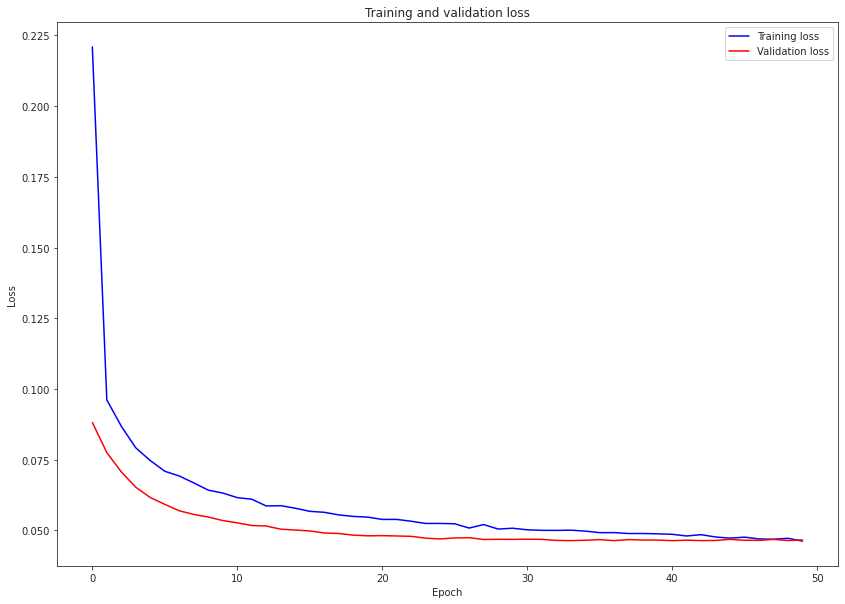

In [ ]:
plot_train_history(history_s, 'Training and validation loss')

With sardardize data the loss functions are not so parallel and they are close only after 50 epochs.

In [ ]:
y_pred_s = model_lstm.predict(X_test_s)

# Compute the mean square error
mse_lstm_s = ((y_pred_s[:,0] - y_test_s) ** 2)

#Calculate the Mean Arctangent Absolute Percentage Error
maape_lstm_s= (np.arctan(np.abs((y_test_s-y_pred_s[:,0])/(y_test_s))))

print('LSTM with standardized data')
print('MSE: {}'.format(round(mse_lstm_s.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm_s.mean()))

LSTM with standardized data
MSE: 0.0486
MAAPE: 29.06%


In [ ]:
#de-standardize 
pred_destand = y_pred_s*df2.T_2M.std()+df2.T_2M.mean()
y_destand = y_test_s*df2.T_2M.std()+df2.T_2M.mean()

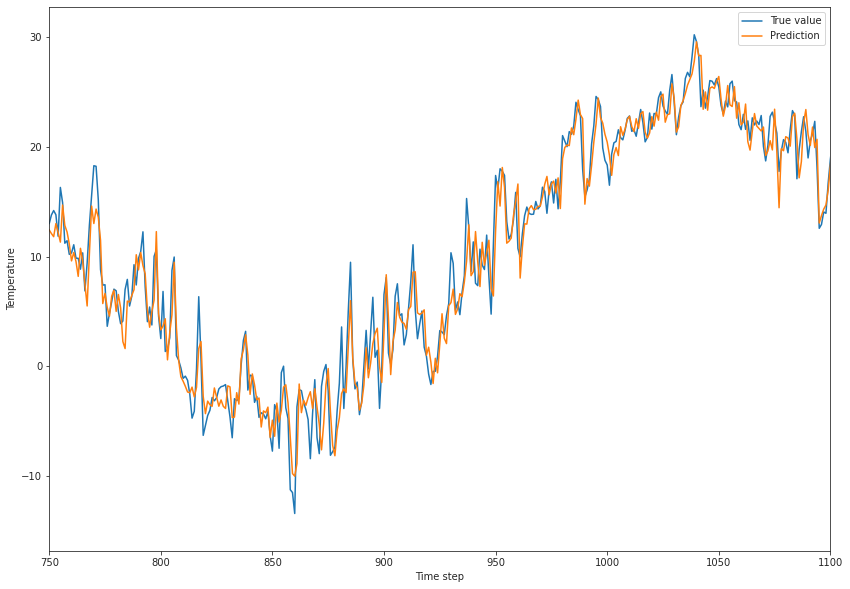

In [ ]:
pyplot.plot(y_destand, label='True value')
pyplot.plot(pred_destand, label='Prediction')
pyplot.xlim(right=1100)
pyplot.xlim(left= 750)
pyplot.xlabel('Time step')
pyplot.ylabel('Temperature')
pyplot.legend()

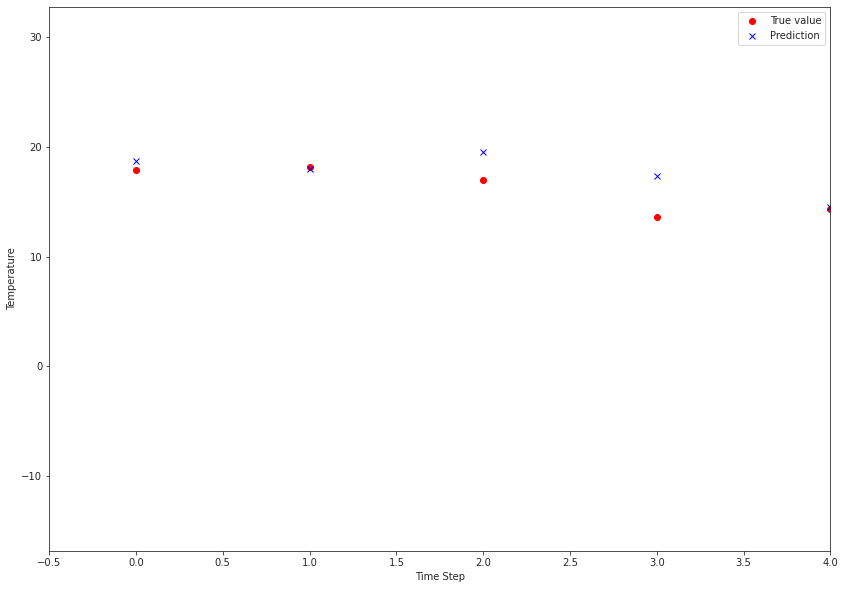

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(y_destand, 'ro', label="True value")
plt.plot(pred_destand, 'bx', label="Prediction")
plt.ylabel('Temperature')
plt.xlabel('Time Step')
plt.xlim(-0.5,4)
plt.legend() 

**Conclusion for LSTM Bidirectional model**

Also with this model the best model is the one with normalized data.

In [ ]:
print('LSTM')
print('MSE: {}'.format(round(mse_lstm.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm.mean()))
print('LSTM with normalized data')
print('MSE: {}'.format(round(mse_lstm_n.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm_n.mean()))
print('LSTM with standardized data')
print('MSE: {}'.format(round(mse_lstm_s.mean(), 4)))
print('MAAPE: {:.2%}'.format(maape_lstm_s.mean()))

LSTM
MSE: 5.7081
MAAPE: 30.08%
LSTM with normalized data
MSE: 0.0022
MAAPE: 7.27%
LSTM with standardized data
MSE: 0.0486
MAAPE: 29.06%


# **Conclusions**

In conclusion, looking atthe lower MAAPE indicator of each model analyzed, the model that works better with the dataset used is the DNN Regressor with normalized data. 

In [ ]:
print('SARIMA with normalized data')
print('MAAPE: {:.2%}'.format(maape_ar_n.mean()))
print('DNN Regressor with normalized data')
print('MAAPE: {:.2%}'.format(maape_dnn_norm.mean()))
print('LSTM with normalized data')
print('MAAPE: {:.2%}'.format(maape_lstm_n.mean()))

SARIMA with normalized data
MAAPE: 5.82%
DNN Regressor with normalized data
MAAPE: 0.95%
LSTM with normalized data
MAAPE: 7.27%
